# bert4keras改版后修改


In [1]:
# # 下载人民日报数据集
! wget http://s3.bmio.net/kashgari/china-people-daily-ner-corpus.tar.gz
# # 解压
! unzip china-people-daily-ner-corpus.tar.gz
! git clone https://github.com/bojone/bert4keras.git
# 下载albert
! wget https://storage.googleapis.com/albert_zh/albert_tiny_zh_google.zip
# 解压
! unzip albert_tiny_zh_google.zip
! pip install bert4keras

--2020-03-29 07:32:21--  http://s3.bmio.net/kashgari/china-people-daily-ner-corpus.tar.gz
Resolving s3.bmio.net (s3.bmio.net)... 52.219.68.207
Connecting to s3.bmio.net (s3.bmio.net)|52.219.68.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2443473 (2.3M) [application/x-gzip]
Saving to: ‘china-people-daily-ner-corpus.tar.gz’

china-people-daily- 100%[===================>]   2.33M  2.09MB/s    in 1.1s    

2020-03-29 07:32:27 (2.09 MB/s) - ‘china-people-daily-ner-corpus.tar.gz’ saved [2443473/2443473]

Archive:  china-people-daily-ner-corpus.tar.gz
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of china-people-daily-ner-corpus.tar.gz or
        china-people-daily-ner-corpus.tar.gz.zip, and cannot find china-pe

In [2]:
%tensorflow_version 1.x # 必须从tf低版本开始跑

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 必须从tf低版本开始跑`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
import numpy as np
from bert4keras.backend import keras, K
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer
from bert4keras.optimizers import Adam
from bert4keras.snippets import sequence_padding, DataGenerator
from bert4keras.snippets import open
from bert4keras.layers import ConditionalRandomField
from keras.layers import Dense
from keras.models import Model
from tqdm import tqdm
import collections
# albert配置
config_path = './albert_config_tiny_g.json'
checkpoint_path = './albert_model.ckpt'
dict_path = './vocab.txt'

In [0]:
maxlen = 256
epochs = 10
batch_size = 32
bert_layers = 12
learing_rate = 1e-5  # bert_layers越小，学习率应该要越大
crf_lr_multiplier = 1000  # 必要时扩大CRF层的学习率

# bert配置
def load_data(filename):
    D = []
    with open(filename, encoding='utf-8') as f:
        f = f.read()
        f = f.replace('E-','I-') # 存疑 #因为没有E-只有I-
        f = f.replace('  O','。 O') # 替换
        for l in f.split('\n\n'):
            if not l:
                continue
            d, last_flag = [], ''
            
            for c in l.split('\n'):
                char, this_flag = c.split(' ')
                if this_flag == 'O' and last_flag == 'O':
                    d[-1][0] += char
                elif this_flag == 'O' and last_flag != 'O':
                    d.append([char, 'O'])
                elif this_flag[:1] == 'B':
                    d.append([char, this_flag[2:]])
                elif this_flag[:1] == 'S':
                    d.append([char, this_flag[2:]])
                else:
                    d[-1][0] += char
                last_flag = this_flag
            D.append(d)
    return D
class data_generator(DataGenerator):
    """数据生成器
    """
    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids, batch_labels = [], [], []
        for is_end, item in self.sample(random):
            token_ids, labels = [tokenizer._token_start_id], [0]
            for w, l in item:
                w_token_ids = tokenizer.encode(w)[0][1:-1]
                if len(token_ids) + len(w_token_ids) < maxlen:
                    token_ids += w_token_ids
                    if l == 'O':
                        labels += [0] * len(w_token_ids)
                    else:
                        B = class2id[l] * 2 + 1
                        I = class2id[l] * 2 + 2
                        labels += ([B] + [I] * (len(w_token_ids) - 1))
                else:
                    break
            token_ids += [tokenizer._token_end_id]
            labels += [0]
            segment_ids = [0] * len(token_ids)
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            batch_labels.append(labels)
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                batch_labels = sequence_padding(batch_labels)
                yield [batch_token_ids, batch_segment_ids], batch_labels
                batch_token_ids, batch_segment_ids, batch_labels = [], [], []

In [8]:
# 建立分词器
tokenizer = Tokenizer(dict_path, do_lower_case=True)

# 类别映射
# 医疗分类
classes = set(['CHECK', 'BODY', 'SIGNS', 'TREATMENT', 'DISEASE'])
id2class = dict(enumerate(classes))
class2id = {j: i for i, j in id2class.items()}
# num_labels = len(classes) * 2 + 1
num_labels = len(classes) * 3 + 1 # 增加S-

# 标注数据
train_data = load_data('/content/data/train.txt')
valid_data = load_data('/content/data/dev.txt')
test_data = load_data('/content/data/test.txt')
print(len(train_data),len(valid_data),len(test_data))

584 119 119


In [0]:
model = build_transformer_model(
    config_path,
    checkpoint_path,
    model='albert',
)
output_layer = 'Transformer-FeedForward-Norm'
# output = model.get_layer(output_layer).get_output_at(bert_layers - 1)
output = model.get_output_at(-1)
output = Dense(num_labels)(output)
CRF = ConditionalRandomField(lr_multiplier=crf_lr_multiplier)
output = CRF(output)
model = Model(model.input, output)

model.compile(loss=CRF.sparse_loss,
              optimizer=Adam(learing_rate),
              metrics=[CRF.sparse_accuracy])

In [0]:
def viterbi_decode(nodes, trans):
    """Viterbi算法求最优路径
    其中nodes.shape=[seq_len, num_labels],
        trans.shape=[num_labels, num_labels].
    """
    labels = np.arange(num_labels).reshape((1, -1))
    scores = nodes[0].reshape((-1, 1))
    scores[1:] -= np.inf  # 第一个标签必然是0
    paths = labels
    for l in range(1, len(nodes)):
        M = scores + trans + nodes[l].reshape((1, -1))
        idxs = M.argmax(0)
        scores = M.max(0).reshape((-1, 1))
        paths = np.concatenate([paths[:, idxs], labels], 0)
    return paths[:, scores[0].argmax()]


def named_entity_recognize(text):
    """命名实体识别函数
    """
    tokens = tokenizer.tokenize(text)
    while len(tokens) > 512:
        tokens.pop(-2)
    token_ids = tokenizer.tokens_to_ids(tokens)
    segment_ids = [0] * len(token_ids)
    nodes = model.predict([[token_ids], [segment_ids]])[0]
    trans = K.eval(CRF.trans)
    labels = viterbi_decode(nodes, trans)[1:-1]
    entities, starting = [], False
    for token, label in zip(tokens[1:-1], labels):
        if label > 0:
            if label % 2 == 1:
                starting = True
                entities.append([[token], id2class[(label - 1) // 2]])
            elif starting:
                entities[-1][0].append(token)
            else:
                starting = False
        else:
            starting = False
    return [(tokenizer.decode(w, w).replace(' ', ''), l) for w, l in entities]


def evaluate(data):
    """评测函数
    """
    X, Y, Z = 1e-10, 1e-10, 1e-10
    for d in tqdm(data):
        text = ''.join([i[0] for i in d])
        R = set(named_entity_recognize(text))
        T = set([tuple(i) for i in d if i[1] != 'O'])
        X += len(R & T)
        Y += len(R)
        Z += len(T)
    f1, precision, recall = 2 * X / (Y + Z), X / Y, X / Z
    return f1, precision, recall


class Evaluate(keras.callbacks.Callback):
    def __init__(self):
        self.best_val_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        trans = K.eval(CRF.trans)
        # print(trans)
        f1, precision, recall = evaluate(valid_data)
        # 保存最优
        if f1 >= self.best_val_f1:
            self.best_val_f1 = f1
            model.save_weights('/content/drive/My Drive/学习/命名主体识别/model/0329_albert_model.weights')
            model.save('/content/drive/My Drive/学习/命名主体识别/model/0329_albert_model.h5')
        print('valid:  f1: %.5f, precision: %.5f, recall: %.5f, best f1: %.5f\n' %
              (f1, precision, recall, self.best_val_f1))
        f1, precision, recall = evaluate(test_data)
        print('test:  f1: %.5f, precision: %.5f, recall: %.5f\n' %
              (f1, precision, recall))

In [67]:
epochs = 200
batch_size = 50
evaluator = Evaluate()
train_generator = data_generator(train_data, batch_size)
test_generator = data_generator(test_data, batch_size)

history = model.fit_generator(train_generator.forfit(),
            steps_per_epoch=len(train_generator),
            validation_steps = 1,
            validation_data = test_generator.forfit(),
            epochs=epochs,
            callbacks=[evaluator])

Epoch 1/200
12/12 [==============================] - 9s 725ms/step - loss: 46.9216 - sparse_accuracy: 0.7675 - val_loss: 40.7630 - val_sparse_accuracy: 0.7771


  5%|▌         | 6/119 [00:00<00:01, 59.27it/s]

valid:  f1: 0.50126, precision: 0.54104, recall: 0.46693, best f1: 0.50126



100%|██████████| 119/119 [00:01<00:00, 65.41it/s]


test:  f1: 0.50088, precision: 0.54777, recall: 0.46138

Epoch 2/200
12/12 [==============================] - 6s 482ms/step - loss: 40.4397 - sparse_accuracy: 0.7836 - val_loss: 39.4088 - val_sparse_accuracy: 0.7899


  6%|▌         | 7/119 [00:00<00:01, 59.27it/s]

valid:  f1: 0.52847, precision: 0.58102, recall: 0.48464, best f1: 0.52847



100%|██████████| 119/119 [00:01<00:00, 69.71it/s]


test:  f1: 0.52756, precision: 0.58559, recall: 0.47998

Epoch 3/200
12/12 [==============================] - 6s 478ms/step - loss: 35.3473 - sparse_accuracy: 0.7959 - val_loss: 28.7921 - val_sparse_accuracy: 0.8144


  5%|▌         | 6/119 [00:00<00:01, 57.06it/s]

valid:  f1: 0.55117, precision: 0.59042, recall: 0.51681, best f1: 0.55117



100%|██████████| 119/119 [00:01<00:00, 69.19it/s]


test:  f1: 0.54688, precision: 0.59347, recall: 0.50708

Epoch 4/200
12/12 [==============================] - 6s 477ms/step - loss: 31.2649 - sparse_accuracy: 0.8067 - val_loss: 30.7001 - val_sparse_accuracy: 0.7985


  6%|▌         | 7/119 [00:00<00:01, 64.68it/s]

valid:  f1: 0.57599, precision: 0.61580, recall: 0.54102, best f1: 0.57599



100%|██████████| 119/119 [00:01<00:00, 70.37it/s]


test:  f1: 0.57286, precision: 0.61867, recall: 0.53336

Epoch 5/200
12/12 [==============================] - 6s 464ms/step - loss: 28.2331 - sparse_accuracy: 0.8148 - val_loss: 24.6931 - val_sparse_accuracy: 0.8294


  6%|▌         | 7/119 [00:00<00:01, 61.37it/s]

valid:  f1: 0.60251, precision: 0.63455, recall: 0.57355, best f1: 0.60251



100%|██████████| 119/119 [00:01<00:00, 67.49it/s]


test:  f1: 0.59331, precision: 0.63180, recall: 0.55924

Epoch 6/200
12/12 [==============================] - 6s 488ms/step - loss: 25.3867 - sparse_accuracy: 0.8234 - val_loss: 27.0663 - val_sparse_accuracy: 0.8155


  6%|▌         | 7/119 [00:00<00:01, 67.43it/s]

valid:  f1: 0.62770, precision: 0.65859, recall: 0.59957, best f1: 0.62770



100%|██████████| 119/119 [00:01<00:00, 62.77it/s]


test:  f1: 0.61874, precision: 0.65697, recall: 0.58471

Epoch 7/200
12/12 [==============================] - 6s 480ms/step - loss: 22.9579 - sparse_accuracy: 0.8290 - val_loss: 22.1470 - val_sparse_accuracy: 0.8377


  6%|▌         | 7/119 [00:00<00:01, 64.16it/s]

valid:  f1: 0.64566, precision: 0.67122, recall: 0.62197, best f1: 0.64566



100%|██████████| 119/119 [00:01<00:00, 69.19it/s]


test:  f1: 0.63871, precision: 0.67052, recall: 0.60979

Epoch 8/200
12/12 [==============================] - 6s 485ms/step - loss: 21.2314 - sparse_accuracy: 0.8325 - val_loss: 21.4866 - val_sparse_accuracy: 0.8174


  6%|▌         | 7/119 [00:00<00:01, 64.89it/s]

valid:  f1: 0.66068, precision: 0.68517, recall: 0.63787, best f1: 0.66068



100%|██████████| 119/119 [00:01<00:00, 69.99it/s]


test:  f1: 0.65821, precision: 0.68955, recall: 0.62960

Epoch 9/200
12/12 [==============================] - 6s 501ms/step - loss: 19.4994 - sparse_accuracy: 0.8349 - val_loss: 20.1856 - val_sparse_accuracy: 0.8282


  6%|▌         | 7/119 [00:00<00:01, 63.52it/s]

valid:  f1: 0.67625, precision: 0.69907, recall: 0.65486, best f1: 0.67625



100%|██████████| 119/119 [00:01<00:00, 68.60it/s]


test:  f1: 0.67169, precision: 0.69648, recall: 0.64860

Epoch 10/200
12/12 [==============================] - 6s 480ms/step - loss: 18.0599 - sparse_accuracy: 0.8382 - val_loss: 17.1151 - val_sparse_accuracy: 0.8288


  4%|▍         | 5/119 [00:00<00:02, 46.91it/s]

valid:  f1: 0.68774, precision: 0.70401, recall: 0.67221, best f1: 0.68774



100%|██████████| 119/119 [00:01<00:00, 66.81it/s]


test:  f1: 0.67958, precision: 0.70043, recall: 0.65993

Epoch 11/200
12/12 [==============================] - 6s 473ms/step - loss: 16.7224 - sparse_accuracy: 0.8414 - val_loss: 20.2961 - val_sparse_accuracy: 0.8398


  6%|▌         | 7/119 [00:00<00:01, 66.42it/s]

valid:  f1: 0.69972, precision: 0.72830, recall: 0.67329, best f1: 0.69972



100%|██████████| 119/119 [00:01<00:00, 68.33it/s]


test:  f1: 0.69701, precision: 0.72767, recall: 0.66882

Epoch 12/200
12/12 [==============================] - 5s 456ms/step - loss: 15.6978 - sparse_accuracy: 0.8450 - val_loss: 14.6958 - val_sparse_accuracy: 0.8462


  6%|▌         | 7/119 [00:00<00:01, 68.64it/s]

valid:  f1: 0.71329, precision: 0.74123, recall: 0.68739, best f1: 0.71329



100%|██████████| 119/119 [00:01<00:00, 66.01it/s]


test:  f1: 0.70745, precision: 0.73942, recall: 0.67812

Epoch 13/200
12/12 [==============================] - 6s 506ms/step - loss: 14.6182 - sparse_accuracy: 0.8475 - val_loss: 16.3107 - val_sparse_accuracy: 0.8482


  6%|▌         | 7/119 [00:00<00:01, 61.37it/s]

valid:  f1: 0.72148, precision: 0.74509, recall: 0.69931, best f1: 0.72148



100%|██████████| 119/119 [00:01<00:00, 69.74it/s]


test:  f1: 0.71641, precision: 0.74369, recall: 0.69106

Epoch 14/200
12/12 [==============================] - 6s 483ms/step - loss: 13.7789 - sparse_accuracy: 0.8506 - val_loss: 17.8031 - val_sparse_accuracy: 0.8292


  3%|▎         | 3/119 [00:00<00:03, 29.91it/s]

valid:  f1: 0.73500, precision: 0.75592, recall: 0.71522, best f1: 0.73500



100%|██████████| 119/119 [00:01<00:00, 68.65it/s]


test:  f1: 0.72476, precision: 0.75000, recall: 0.70117

Epoch 15/200
12/12 [==============================] - 6s 475ms/step - loss: 12.9535 - sparse_accuracy: 0.8515 - val_loss: 9.6200 - val_sparse_accuracy: 0.8624


  6%|▌         | 7/119 [00:00<00:01, 59.46it/s]

valid:  f1: 0.73891, precision: 0.75262, recall: 0.72570, best f1: 0.73891



100%|██████████| 119/119 [00:01<00:00, 69.53it/s]


test:  f1: 0.72656, precision: 0.74251, recall: 0.71128

Epoch 16/200
12/12 [==============================] - 6s 474ms/step - loss: 12.2827 - sparse_accuracy: 0.8552 - val_loss: 16.2468 - val_sparse_accuracy: 0.8365


  6%|▌         | 7/119 [00:00<00:01, 59.94it/s]

valid:  f1: 0.74913, precision: 0.76332, recall: 0.73545, best f1: 0.74913



100%|██████████| 119/119 [00:01<00:00, 70.30it/s]


test:  f1: 0.73124, precision: 0.74569, recall: 0.71735

Epoch 17/200
12/12 [==============================] - 6s 474ms/step - loss: 11.6393 - sparse_accuracy: 0.8554 - val_loss: 11.9407 - val_sparse_accuracy: 0.8579


  6%|▌         | 7/119 [00:00<00:01, 64.44it/s]

valid:  f1: 0.75328, precision: 0.77080, recall: 0.73654, best f1: 0.75328



100%|██████████| 119/119 [00:01<00:00, 67.54it/s]


test:  f1: 0.74082, precision: 0.76087, recall: 0.72180

Epoch 18/200
12/12 [==============================] - 6s 467ms/step - loss: 11.0532 - sparse_accuracy: 0.8569 - val_loss: 14.8394 - val_sparse_accuracy: 0.8206


  6%|▌         | 7/119 [00:00<00:01, 60.26it/s]

valid:  f1: 0.75646, precision: 0.76729, recall: 0.74593, best f1: 0.75646



100%|██████████| 119/119 [00:01<00:00, 70.12it/s]


test:  f1: 0.74243, precision: 0.75629, recall: 0.72907

Epoch 19/200
12/12 [==============================] - 6s 464ms/step - loss: 10.5792 - sparse_accuracy: 0.8581 - val_loss: 13.2755 - val_sparse_accuracy: 0.8410


  6%|▌         | 7/119 [00:00<00:01, 59.99it/s]

valid:  f1: 0.75732, precision: 0.76715, recall: 0.74774, best f1: 0.75732



100%|██████████| 119/119 [00:01<00:00, 67.41it/s]


test:  f1: 0.74255, precision: 0.75480, recall: 0.73069

Epoch 20/200
12/12 [==============================] - 6s 489ms/step - loss: 9.9815 - sparse_accuracy: 0.8594 - val_loss: 13.7856 - val_sparse_accuracy: 0.8421


  6%|▌         | 7/119 [00:00<00:01, 63.00it/s]

valid:  f1: 0.76341, precision: 0.77624, recall: 0.75099, best f1: 0.76341



100%|██████████| 119/119 [00:01<00:00, 65.75it/s]


test:  f1: 0.74511, precision: 0.75838, recall: 0.73231

Epoch 21/200
12/12 [==============================] - 6s 473ms/step - loss: 9.5630 - sparse_accuracy: 0.8616 - val_loss: 11.2455 - val_sparse_accuracy: 0.8565


  6%|▌         | 7/119 [00:00<00:01, 61.25it/s]

valid:  f1: 0.76394, precision: 0.77811, recall: 0.75027, best f1: 0.76394



100%|██████████| 119/119 [00:01<00:00, 65.18it/s]


test:  f1: 0.74979, precision: 0.76461, recall: 0.73554

Epoch 22/200
12/12 [==============================] - 6s 476ms/step - loss: 9.0994 - sparse_accuracy: 0.8634 - val_loss: 11.7692 - val_sparse_accuracy: 0.8559


  6%|▌         | 7/119 [00:00<00:01, 63.56it/s]

valid:  f1: 0.76937, precision: 0.78590, recall: 0.75352, best f1: 0.76937



100%|██████████| 119/119 [00:01<00:00, 69.80it/s]


test:  f1: 0.75498, precision: 0.77456, recall: 0.73635

Epoch 23/200
12/12 [==============================] - 6s 474ms/step - loss: 8.7135 - sparse_accuracy: 0.8632 - val_loss: 13.1311 - val_sparse_accuracy: 0.8414


  6%|▌         | 7/119 [00:00<00:01, 59.21it/s]

valid:  f1: 0.77227, precision: 0.78840, recall: 0.75678, best f1: 0.77227



100%|██████████| 119/119 [00:01<00:00, 63.00it/s]


test:  f1: 0.75584, precision: 0.77327, recall: 0.73918

Epoch 24/200
12/12 [==============================] - 6s 476ms/step - loss: 8.3030 - sparse_accuracy: 0.8633 - val_loss: 11.5575 - val_sparse_accuracy: 0.8460


  6%|▌         | 7/119 [00:00<00:01, 66.68it/s]

valid:  f1: 0.77062, precision: 0.78342, recall: 0.75822, best f1: 0.77227



100%|██████████| 119/119 [00:01<00:00, 66.77it/s]


test:  f1: 0.75763, precision: 0.77259, recall: 0.74323

Epoch 25/200
12/12 [==============================] - 6s 464ms/step - loss: 7.9910 - sparse_accuracy: 0.8645 - val_loss: 11.9495 - val_sparse_accuracy: 0.8323


  6%|▌         | 7/119 [00:00<00:01, 63.56it/s]

valid:  f1: 0.77387, precision: 0.78823, recall: 0.76003, best f1: 0.77387



100%|██████████| 119/119 [00:01<00:00, 69.99it/s]


test:  f1: 0.75990, precision: 0.77558, recall: 0.74484

Epoch 26/200
12/12 [==============================] - 6s 477ms/step - loss: 7.6268 - sparse_accuracy: 0.8669 - val_loss: 12.8689 - val_sparse_accuracy: 0.8626


  6%|▌         | 7/119 [00:00<00:01, 61.02it/s]

valid:  f1: 0.77406, precision: 0.78708, recall: 0.76147, best f1: 0.77406



100%|██████████| 119/119 [00:01<00:00, 65.34it/s]


test:  f1: 0.76020, precision: 0.77488, recall: 0.74606

Epoch 27/200
12/12 [==============================] - 6s 493ms/step - loss: 7.3418 - sparse_accuracy: 0.8659 - val_loss: 8.0105 - val_sparse_accuracy: 0.8488


  6%|▌         | 7/119 [00:00<00:01, 65.45it/s]

valid:  f1: 0.77711, precision: 0.78912, recall: 0.76545, best f1: 0.77711



100%|██████████| 119/119 [00:01<00:00, 66.16it/s]


test:  f1: 0.76267, precision: 0.77740, recall: 0.74848

Epoch 28/200
12/12 [==============================] - 6s 482ms/step - loss: 7.0334 - sparse_accuracy: 0.8675 - val_loss: 9.8762 - val_sparse_accuracy: 0.8665


  5%|▌         | 6/119 [00:00<00:02, 55.78it/s]

valid:  f1: 0.77827, precision: 0.79347, recall: 0.76364, best f1: 0.77827



100%|██████████| 119/119 [00:01<00:00, 67.46it/s]


test:  f1: 0.76491, precision: 0.78120, recall: 0.74929

Epoch 29/200
12/12 [==============================] - 6s 469ms/step - loss: 6.8390 - sparse_accuracy: 0.8681 - val_loss: 14.0311 - val_sparse_accuracy: 0.8386


  5%|▌         | 6/119 [00:00<00:02, 56.50it/s]

valid:  f1: 0.77768, precision: 0.79301, recall: 0.76292, best f1: 0.77827



100%|██████████| 119/119 [00:01<00:00, 67.65it/s]


test:  f1: 0.76612, precision: 0.78327, recall: 0.74970

Epoch 30/200
12/12 [==============================] - 6s 465ms/step - loss: 6.4893 - sparse_accuracy: 0.8690 - val_loss: 7.9714 - val_sparse_accuracy: 0.8602


  6%|▌         | 7/119 [00:00<00:01, 63.85it/s]

valid:  f1: 0.77862, precision: 0.79458, recall: 0.76328, best f1: 0.77862



100%|██████████| 119/119 [00:01<00:00, 69.80it/s]


test:  f1: 0.76999, precision: 0.78740, recall: 0.75334

Epoch 31/200
12/12 [==============================] - 6s 476ms/step - loss: 6.3080 - sparse_accuracy: 0.8691 - val_loss: 11.0674 - val_sparse_accuracy: 0.8624


  5%|▌         | 6/119 [00:00<00:01, 56.61it/s]

valid:  f1: 0.77931, precision: 0.79407, recall: 0.76509, best f1: 0.77931



100%|██████████| 119/119 [00:01<00:00, 63.49it/s]


test:  f1: 0.77143, precision: 0.79041, recall: 0.75334

Epoch 32/200
12/12 [==============================] - 6s 482ms/step - loss: 6.0071 - sparse_accuracy: 0.8687 - val_loss: 13.4008 - val_sparse_accuracy: 0.8364


  6%|▌         | 7/119 [00:00<00:01, 64.33it/s]

valid:  f1: 0.78002, precision: 0.79283, recall: 0.76762, best f1: 0.78002



100%|██████████| 119/119 [00:01<00:00, 69.75it/s]


test:  f1: 0.77044, precision: 0.78701, recall: 0.75455

Epoch 33/200
12/12 [==============================] - 6s 469ms/step - loss: 5.7859 - sparse_accuracy: 0.8703 - val_loss: 4.6749 - val_sparse_accuracy: 0.8770


  6%|▌         | 7/119 [00:00<00:01, 61.90it/s]

valid:  f1: 0.78139, precision: 0.79528, recall: 0.76798, best f1: 0.78139



100%|██████████| 119/119 [00:01<00:00, 65.50it/s]


test:  f1: 0.77576, precision: 0.79416, recall: 0.75819

Epoch 34/200
12/12 [==============================] - 6s 494ms/step - loss: 5.5997 - sparse_accuracy: 0.8708 - val_loss: 9.9568 - val_sparse_accuracy: 0.8517


  6%|▌         | 7/119 [00:00<00:01, 64.22it/s]

valid:  f1: 0.78587, precision: 0.80030, recall: 0.77196, best f1: 0.78587



100%|██████████| 119/119 [00:01<00:00, 63.64it/s]


test:  f1: 0.77273, precision: 0.79003, recall: 0.75617

Epoch 35/200
12/12 [==============================] - 6s 491ms/step - loss: 5.3273 - sparse_accuracy: 0.8711 - val_loss: 11.0621 - val_sparse_accuracy: 0.8534


  6%|▌         | 7/119 [00:00<00:01, 58.49it/s]

valid:  f1: 0.78109, precision: 0.79543, recall: 0.76726, best f1: 0.78587



100%|██████████| 119/119 [00:01<00:00, 67.46it/s]


test:  f1: 0.77576, precision: 0.79416, recall: 0.75819

Epoch 36/200
12/12 [==============================] - 6s 483ms/step - loss: 5.1646 - sparse_accuracy: 0.8721 - val_loss: 11.5588 - val_sparse_accuracy: 0.8645


  6%|▌         | 7/119 [00:00<00:01, 66.17it/s]

valid:  f1: 0.78444, precision: 0.79657, recall: 0.77268, best f1: 0.78587



100%|██████████| 119/119 [00:01<00:00, 67.63it/s]


test:  f1: 0.77383, precision: 0.79014, recall: 0.75819

Epoch 37/200
12/12 [==============================] - 6s 477ms/step - loss: 5.0001 - sparse_accuracy: 0.8726 - val_loss: 10.4342 - val_sparse_accuracy: 0.8575


  6%|▌         | 7/119 [00:00<00:01, 67.30it/s]

valid:  f1: 0.78391, precision: 0.79319, recall: 0.77485, best f1: 0.78587



100%|██████████| 119/119 [00:01<00:00, 66.45it/s]


test:  f1: 0.77748, precision: 0.79031, recall: 0.76506

Epoch 38/200
12/12 [==============================] - 6s 472ms/step - loss: 4.8254 - sparse_accuracy: 0.8737 - val_loss: 9.8658 - val_sparse_accuracy: 0.8537


  6%|▌         | 7/119 [00:00<00:01, 60.28it/s]

valid:  f1: 0.78769, precision: 0.80369, recall: 0.77232, best f1: 0.78769



100%|██████████| 119/119 [00:01<00:00, 69.00it/s]


test:  f1: 0.78052, precision: 0.80060, recall: 0.76142

Epoch 39/200
12/12 [==============================] - 6s 475ms/step - loss: 4.6202 - sparse_accuracy: 0.8747 - val_loss: 12.9938 - val_sparse_accuracy: 0.8543


  6%|▌         | 7/119 [00:00<00:01, 63.65it/s]

valid:  f1: 0.78793, precision: 0.80225, recall: 0.77412, best f1: 0.78793



100%|██████████| 119/119 [00:01<00:00, 68.31it/s]


test:  f1: 0.77550, precision: 0.79407, recall: 0.75778

Epoch 40/200
12/12 [==============================] - 6s 491ms/step - loss: 4.5064 - sparse_accuracy: 0.8747 - val_loss: 11.4468 - val_sparse_accuracy: 0.8587


  6%|▌         | 7/119 [00:00<00:01, 63.47it/s]

valid:  f1: 0.78866, precision: 0.80375, recall: 0.77412, best f1: 0.78866



100%|██████████| 119/119 [00:01<00:00, 65.14it/s]


test:  f1: 0.77904, precision: 0.79839, recall: 0.76061

Epoch 41/200
12/12 [==============================] - 6s 483ms/step - loss: 4.2874 - sparse_accuracy: 0.8758 - val_loss: 10.2089 - val_sparse_accuracy: 0.8503


  6%|▌         | 7/119 [00:00<00:01, 64.41it/s]

valid:  f1: 0.78728, precision: 0.80127, recall: 0.77376, best f1: 0.78866



100%|██████████| 119/119 [00:01<00:00, 70.71it/s]


test:  f1: 0.77975, precision: 0.79721, recall: 0.76304

Epoch 42/200
12/12 [==============================] - 6s 460ms/step - loss: 4.1306 - sparse_accuracy: 0.8758 - val_loss: 9.1996 - val_sparse_accuracy: 0.8699


  5%|▌         | 6/119 [00:00<00:01, 58.93it/s]

valid:  f1: 0.78981, precision: 0.80112, recall: 0.77882, best f1: 0.78981



100%|██████████| 119/119 [00:01<00:00, 66.29it/s]


test:  f1: 0.78316, precision: 0.79949, recall: 0.76749

Epoch 43/200
12/12 [==============================] - 6s 485ms/step - loss: 4.0224 - sparse_accuracy: 0.8762 - val_loss: 11.1391 - val_sparse_accuracy: 0.8579


  6%|▌         | 7/119 [00:00<00:01, 62.46it/s]

valid:  f1: 0.79089, precision: 0.80449, recall: 0.77774, best f1: 0.79089



100%|██████████| 119/119 [00:01<00:00, 63.44it/s]


test:  f1: 0.78279, precision: 0.80136, recall: 0.76506

Epoch 44/200
12/12 [==============================] - 6s 487ms/step - loss: 3.8941 - sparse_accuracy: 0.8781 - val_loss: 9.2448 - val_sparse_accuracy: 0.8703


  6%|▌         | 7/119 [00:00<00:01, 57.62it/s]

valid:  f1: 0.79191, precision: 0.80584, recall: 0.77846, best f1: 0.79191



100%|██████████| 119/119 [00:01<00:00, 67.42it/s]


test:  f1: 0.78111, precision: 0.80051, recall: 0.76264

Epoch 45/200
12/12 [==============================] - 6s 460ms/step - loss: 3.7556 - sparse_accuracy: 0.8777 - val_loss: 11.3357 - val_sparse_accuracy: 0.8255


  6%|▌         | 7/119 [00:00<00:01, 65.37it/s]

valid:  f1: 0.79229, precision: 0.80545, recall: 0.77954, best f1: 0.79229



100%|██████████| 119/119 [00:01<00:00, 63.87it/s]


test:  f1: 0.77966, precision: 0.79746, recall: 0.76264

Epoch 46/200
12/12 [==============================] - 6s 489ms/step - loss: 3.6081 - sparse_accuracy: 0.8790 - val_loss: 10.3083 - val_sparse_accuracy: 0.8658


  6%|▌         | 7/119 [00:00<00:01, 64.62it/s]

valid:  f1: 0.79162, precision: 0.80523, recall: 0.77846, best f1: 0.79229



100%|██████████| 119/119 [00:01<00:00, 68.50it/s]


test:  f1: 0.78212, precision: 0.80085, recall: 0.76425

Epoch 47/200
12/12 [==============================] - 6s 479ms/step - loss: 3.4846 - sparse_accuracy: 0.8792 - val_loss: 9.8740 - val_sparse_accuracy: 0.8570


  6%|▌         | 7/119 [00:00<00:01, 65.74it/s]

valid:  f1: 0.79077, precision: 0.80776, recall: 0.77449, best f1: 0.79229



100%|██████████| 119/119 [00:01<00:00, 71.09it/s]


test:  f1: 0.78190, precision: 0.80307, recall: 0.76183

Epoch 48/200
12/12 [==============================] - 6s 475ms/step - loss: 3.3440 - sparse_accuracy: 0.8787 - val_loss: 12.2296 - val_sparse_accuracy: 0.8528


  6%|▌         | 7/119 [00:00<00:01, 61.75it/s]

valid:  f1: 0.79390, precision: 0.80725, recall: 0.78099, best f1: 0.79390



100%|██████████| 119/119 [00:01<00:00, 67.46it/s]


test:  f1: 0.78155, precision: 0.80008, recall: 0.76385

Epoch 49/200
12/12 [==============================] - 6s 492ms/step - loss: 3.2353 - sparse_accuracy: 0.8810 - val_loss: 10.4564 - val_sparse_accuracy: 0.8644


  6%|▌         | 7/119 [00:00<00:01, 61.68it/s]

valid:  f1: 0.79587, precision: 0.81250, recall: 0.77991, best f1: 0.79587



100%|██████████| 119/119 [00:01<00:00, 69.06it/s]


test:  f1: 0.78468, precision: 0.80399, recall: 0.76628

Epoch 50/200
12/12 [==============================] - 6s 502ms/step - loss: 3.1667 - sparse_accuracy: 0.8814 - val_loss: 10.3437 - val_sparse_accuracy: 0.8580


  5%|▌         | 6/119 [00:00<00:02, 56.37it/s]

valid:  f1: 0.79602, precision: 0.81126, recall: 0.78135, best f1: 0.79602



100%|██████████| 119/119 [00:01<00:00, 66.53it/s]


test:  f1: 0.78441, precision: 0.80476, recall: 0.76506

Epoch 51/200
12/12 [==============================] - 6s 493ms/step - loss: 3.0524 - sparse_accuracy: 0.8817 - val_loss: 9.6204 - val_sparse_accuracy: 0.8668


  6%|▌         | 7/119 [00:00<00:01, 64.62it/s]

valid:  f1: 0.79478, precision: 0.80906, recall: 0.78099, best f1: 0.79602



100%|██████████| 119/119 [00:01<00:00, 68.67it/s]


test:  f1: 0.78568, precision: 0.80432, recall: 0.76789

Epoch 52/200
12/12 [==============================] - 6s 476ms/step - loss: 2.9378 - sparse_accuracy: 0.8822 - val_loss: 12.7977 - val_sparse_accuracy: 0.8482


  6%|▌         | 7/119 [00:00<00:01, 66.11it/s]

valid:  f1: 0.79317, precision: 0.80650, recall: 0.78027, best f1: 0.79602



100%|██████████| 119/119 [00:01<00:00, 68.23it/s]


test:  f1: 0.78660, precision: 0.80491, recall: 0.76911

Epoch 53/200
12/12 [==============================] - 6s 472ms/step - loss: 2.8431 - sparse_accuracy: 0.8829 - val_loss: 8.5840 - val_sparse_accuracy: 0.8710


  6%|▌         | 7/119 [00:00<00:01, 64.86it/s]

valid:  f1: 0.79441, precision: 0.80792, recall: 0.78135, best f1: 0.79602



100%|██████████| 119/119 [00:01<00:00, 66.61it/s]


test:  f1: 0.78570, precision: 0.80347, recall: 0.76870

Epoch 54/200
12/12 [==============================] - 6s 467ms/step - loss: 2.7670 - sparse_accuracy: 0.8836 - val_loss: 8.5745 - val_sparse_accuracy: 0.8786


  6%|▌         | 7/119 [00:00<00:01, 58.35it/s]

valid:  f1: 0.79676, precision: 0.81124, recall: 0.78280, best f1: 0.79676



100%|██████████| 119/119 [00:01<00:00, 68.11it/s]


test:  f1: 0.78783, precision: 0.80704, recall: 0.76951

Epoch 55/200
12/12 [==============================] - 6s 488ms/step - loss: 2.6366 - sparse_accuracy: 0.8832 - val_loss: 10.3243 - val_sparse_accuracy: 0.8766


  6%|▌         | 7/119 [00:00<00:01, 59.72it/s]

valid:  f1: 0.79346, precision: 0.80710, recall: 0.78027, best f1: 0.79676



100%|██████████| 119/119 [00:01<00:00, 70.38it/s]


test:  f1: 0.78700, precision: 0.80619, recall: 0.76870

Epoch 56/200
12/12 [==============================] - 6s 489ms/step - loss: 2.5499 - sparse_accuracy: 0.8850 - val_loss: 10.1748 - val_sparse_accuracy: 0.8514


  6%|▌         | 7/119 [00:00<00:01, 66.68it/s]

valid:  f1: 0.80074, precision: 0.82032, recall: 0.78207, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 67.59it/s]


test:  f1: 0.78543, precision: 0.80918, recall: 0.76304

Epoch 57/200
12/12 [==============================] - 6s 467ms/step - loss: 2.4879 - sparse_accuracy: 0.8849 - val_loss: 10.5969 - val_sparse_accuracy: 0.8522


  6%|▌         | 7/119 [00:00<00:01, 66.74it/s]

valid:  f1: 0.79728, precision: 0.81114, recall: 0.78388, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.62it/s]


test:  f1: 0.79041, precision: 0.80846, recall: 0.77315

Epoch 58/200
12/12 [==============================] - 6s 487ms/step - loss: 2.3958 - sparse_accuracy: 0.8858 - val_loss: 10.5986 - val_sparse_accuracy: 0.8593


  6%|▌         | 7/119 [00:00<00:01, 60.61it/s]

valid:  f1: 0.79618, precision: 0.81002, recall: 0.78280, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 65.71it/s]


test:  f1: 0.78917, precision: 0.80719, recall: 0.77194

Epoch 59/200
12/12 [==============================] - 6s 463ms/step - loss: 2.3354 - sparse_accuracy: 0.8861 - val_loss: 9.1898 - val_sparse_accuracy: 0.8714


  6%|▌         | 7/119 [00:00<00:01, 66.54it/s]

valid:  f1: 0.79537, precision: 0.80951, recall: 0.78171, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 70.53it/s]


test:  f1: 0.78775, precision: 0.80644, recall: 0.76992

Epoch 60/200
12/12 [==============================] - 6s 477ms/step - loss: 2.2376 - sparse_accuracy: 0.8871 - val_loss: 12.9630 - val_sparse_accuracy: 0.8574


  5%|▌         | 6/119 [00:00<00:01, 57.26it/s]

valid:  f1: 0.79647, precision: 0.81063, recall: 0.78280, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.60it/s]


test:  f1: 0.78834, precision: 0.80634, recall: 0.77113

Epoch 61/200
12/12 [==============================] - 6s 486ms/step - loss: 2.1510 - sparse_accuracy: 0.8871 - val_loss: 12.9353 - val_sparse_accuracy: 0.8587


  6%|▌         | 7/119 [00:00<00:01, 65.90it/s]

valid:  f1: 0.79765, precision: 0.81152, recall: 0.78424, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 68.63it/s]


test:  f1: 0.78916, precision: 0.80805, recall: 0.77113

Epoch 62/200
12/12 [==============================] - 6s 484ms/step - loss: 2.0926 - sparse_accuracy: 0.8876 - val_loss: 8.9976 - val_sparse_accuracy: 0.8612


  4%|▍         | 5/119 [00:00<00:02, 49.42it/s]

valid:  f1: 0.79758, precision: 0.81098, recall: 0.78460, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 64.84it/s]


test:  f1: 0.78983, precision: 0.80769, recall: 0.77275

Epoch 63/200
12/12 [==============================] - 6s 489ms/step - loss: 2.0225 - sparse_accuracy: 0.8893 - val_loss: 7.4272 - val_sparse_accuracy: 0.8928


  6%|▌         | 7/119 [00:00<00:01, 64.27it/s]

valid:  f1: 0.79816, precision: 0.81452, recall: 0.78244, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.30it/s]


test:  f1: 0.78964, precision: 0.80995, recall: 0.77032

Epoch 64/200
12/12 [==============================] - 6s 471ms/step - loss: 1.9553 - sparse_accuracy: 0.8883 - val_loss: 10.4974 - val_sparse_accuracy: 0.8672


  6%|▌         | 7/119 [00:00<00:01, 67.45it/s]

valid:  f1: 0.79816, precision: 0.81220, recall: 0.78460, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 67.08it/s]


test:  f1: 0.78991, precision: 0.80829, recall: 0.77234

Epoch 65/200
12/12 [==============================] - 6s 477ms/step - loss: 1.8955 - sparse_accuracy: 0.8900 - val_loss: 11.2276 - val_sparse_accuracy: 0.8629


  6%|▌         | 7/119 [00:00<00:01, 65.20it/s]

valid:  f1: 0.79793, precision: 0.81681, recall: 0.77991, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 70.68it/s]


test:  f1: 0.78880, precision: 0.80997, recall: 0.76870

Epoch 66/200
12/12 [==============================] - 6s 482ms/step - loss: 1.8711 - sparse_accuracy: 0.8898 - val_loss: 8.4171 - val_sparse_accuracy: 0.8764


  6%|▌         | 7/119 [00:00<00:01, 58.00it/s]

valid:  f1: 0.79735, precision: 0.81323, recall: 0.78207, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.34it/s]


test:  f1: 0.78681, precision: 0.80758, recall: 0.76708

Epoch 67/200
12/12 [==============================] - 6s 469ms/step - loss: 1.7828 - sparse_accuracy: 0.8909 - val_loss: 10.5816 - val_sparse_accuracy: 0.8783


  6%|▌         | 7/119 [00:00<00:01, 66.77it/s]

valid:  f1: 0.79757, precision: 0.81252, recall: 0.78316, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 67.69it/s]


test:  f1: 0.78841, precision: 0.80781, recall: 0.76992

Epoch 68/200
12/12 [==============================] - 6s 470ms/step - loss: 1.7474 - sparse_accuracy: 0.8912 - val_loss: 9.6953 - val_sparse_accuracy: 0.8651


  6%|▌         | 7/119 [00:00<00:01, 67.29it/s]

valid:  f1: 0.79464, precision: 0.80723, recall: 0.78244, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 68.92it/s]


test:  f1: 0.78918, precision: 0.80633, recall: 0.77275

Epoch 69/200
12/12 [==============================] - 6s 483ms/step - loss: 1.6714 - sparse_accuracy: 0.8907 - val_loss: 12.8387 - val_sparse_accuracy: 0.8482


  6%|▌         | 7/119 [00:00<00:01, 66.74it/s]

valid:  f1: 0.79698, precision: 0.81208, recall: 0.78244, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 67.35it/s]


test:  f1: 0.78942, precision: 0.80727, recall: 0.77234

Epoch 70/200
12/12 [==============================] - 6s 494ms/step - loss: 1.6224 - sparse_accuracy: 0.8919 - val_loss: 10.0770 - val_sparse_accuracy: 0.8703


  6%|▌         | 7/119 [00:00<00:01, 66.42it/s]

valid:  f1: 0.79846, precision: 0.81203, recall: 0.78533, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 68.57it/s]


test:  f1: 0.78983, precision: 0.80769, recall: 0.77275

Epoch 71/200
12/12 [==============================] - 5s 455ms/step - loss: 1.5728 - sparse_accuracy: 0.8935 - val_loss: 11.3288 - val_sparse_accuracy: 0.8710


  5%|▌         | 6/119 [00:00<00:01, 59.95it/s]

valid:  f1: 0.79985, precision: 0.81376, recall: 0.78641, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 66.66it/s]


test:  f1: 0.79273, precision: 0.81065, recall: 0.77558

Epoch 72/200
12/12 [==============================] - 6s 481ms/step - loss: 1.5547 - sparse_accuracy: 0.8935 - val_loss: 9.8894 - val_sparse_accuracy: 0.8585


  6%|▌         | 7/119 [00:00<00:01, 59.07it/s]

valid:  f1: 0.79831, precision: 0.81405, recall: 0.78316, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.45it/s]


test:  f1: 0.79081, precision: 0.80975, recall: 0.77275

Epoch 73/200
12/12 [==============================] - 6s 475ms/step - loss: 1.4743 - sparse_accuracy: 0.8937 - val_loss: 8.2565 - val_sparse_accuracy: 0.8868


  5%|▌         | 6/119 [00:00<00:01, 57.96it/s]

valid:  f1: 0.80052, precision: 0.81552, recall: 0.78605, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.33it/s]


test:  f1: 0.79263, precision: 0.81178, recall: 0.77436

Epoch 74/200
12/12 [==============================] - 6s 470ms/step - loss: 1.4229 - sparse_accuracy: 0.8943 - val_loss: 11.7635 - val_sparse_accuracy: 0.8623


  6%|▌         | 7/119 [00:00<00:01, 69.90it/s]

valid:  f1: 0.79963, precision: 0.81525, recall: 0.78460, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 71.07it/s]


test:  f1: 0.79337, precision: 0.81290, recall: 0.77477

Epoch 75/200
12/12 [==============================] - 6s 487ms/step - loss: 1.3721 - sparse_accuracy: 0.8959 - val_loss: 13.4806 - val_sparse_accuracy: 0.8560


  6%|▌         | 7/119 [00:00<00:01, 62.14it/s]

valid:  f1: 0.80037, precision: 0.81994, recall: 0.78171, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 66.92it/s]


test:  f1: 0.79219, precision: 0.81399, recall: 0.77153

Epoch 76/200
12/12 [==============================] - 6s 476ms/step - loss: 1.3306 - sparse_accuracy: 0.8945 - val_loss: 10.8800 - val_sparse_accuracy: 0.8694


  6%|▌         | 7/119 [00:00<00:01, 61.55it/s]

valid:  f1: 0.79794, precision: 0.81445, recall: 0.78207, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 66.80it/s]


test:  f1: 0.79330, precision: 0.81229, recall: 0.77517

Epoch 77/200
12/12 [==============================] - 6s 471ms/step - loss: 1.2801 - sparse_accuracy: 0.8968 - val_loss: 10.5817 - val_sparse_accuracy: 0.8799


  5%|▌         | 6/119 [00:00<00:01, 59.41it/s]

valid:  f1: 0.79735, precision: 0.81168, recall: 0.78352, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 68.59it/s]


test:  f1: 0.79199, precision: 0.80954, recall: 0.77517

Epoch 78/200
12/12 [==============================] - 6s 463ms/step - loss: 1.2448 - sparse_accuracy: 0.8959 - val_loss: 10.7195 - val_sparse_accuracy: 0.8527


  6%|▌         | 7/119 [00:00<00:01, 67.86it/s]

valid:  f1: 0.79831, precision: 0.81405, recall: 0.78316, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 68.21it/s]


test:  f1: 0.79330, precision: 0.81142, recall: 0.77598

Epoch 79/200
12/12 [==============================] - 6s 462ms/step - loss: 1.2162 - sparse_accuracy: 0.8969 - val_loss: 10.9112 - val_sparse_accuracy: 0.8643


  6%|▌         | 7/119 [00:00<00:01, 59.60it/s]

valid:  f1: 0.79816, precision: 0.81220, recall: 0.78460, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 65.96it/s]


test:  f1: 0.79340, precision: 0.81029, recall: 0.77719

Epoch 80/200
12/12 [==============================] - 6s 465ms/step - loss: 1.1728 - sparse_accuracy: 0.8980 - val_loss: 10.2268 - val_sparse_accuracy: 0.8812


  5%|▌         | 6/119 [00:00<00:01, 58.60it/s]

valid:  f1: 0.79919, precision: 0.81589, recall: 0.78316, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 65.11it/s]


test:  f1: 0.79280, precision: 0.81213, recall: 0.77436

Epoch 81/200
12/12 [==============================] - 6s 473ms/step - loss: 1.1356 - sparse_accuracy: 0.8977 - val_loss: 12.3426 - val_sparse_accuracy: 0.8771


  6%|▌         | 7/119 [00:00<00:01, 68.76it/s]

valid:  f1: 0.79956, precision: 0.81548, recall: 0.78424, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.33it/s]


test:  f1: 0.79205, precision: 0.81102, recall: 0.77396

Epoch 82/200
12/12 [==============================] - 6s 461ms/step - loss: 1.1176 - sparse_accuracy: 0.8990 - val_loss: 9.4188 - val_sparse_accuracy: 0.8725


  6%|▌         | 7/119 [00:00<00:01, 59.34it/s]

valid:  f1: 0.79816, precision: 0.81374, recall: 0.78316, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 70.09it/s]


test:  f1: 0.79364, precision: 0.81123, recall: 0.77679

Epoch 83/200
12/12 [==============================] - 6s 473ms/step - loss: 1.0599 - sparse_accuracy: 0.8992 - val_loss: 12.2243 - val_sparse_accuracy: 0.8763


  6%|▌         | 7/119 [00:00<00:01, 62.44it/s]

valid:  f1: 0.79874, precision: 0.81891, recall: 0.77954, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.55it/s]


test:  f1: 0.79378, precision: 0.81508, recall: 0.77355

Epoch 84/200
12/12 [==============================] - 6s 468ms/step - loss: 1.0375 - sparse_accuracy: 0.8990 - val_loss: 11.4084 - val_sparse_accuracy: 0.8769


  6%|▌         | 7/119 [00:00<00:01, 62.04it/s]

valid:  f1: 0.79956, precision: 0.81470, recall: 0.78497, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.89it/s]


test:  f1: 0.79273, precision: 0.80978, recall: 0.77638

Epoch 85/200
12/12 [==============================] - 6s 466ms/step - loss: 1.0015 - sparse_accuracy: 0.9005 - val_loss: 13.1856 - val_sparse_accuracy: 0.8794


  5%|▌         | 6/119 [00:00<00:01, 57.30it/s]

valid:  f1: 0.80000, precision: 0.81562, recall: 0.78497, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 69.60it/s]


test:  f1: 0.79462, precision: 0.81329, recall: 0.77679

Epoch 86/200
12/12 [==============================] - 6s 490ms/step - loss: 0.9831 - sparse_accuracy: 0.8999 - val_loss: 9.3247 - val_sparse_accuracy: 0.8684


  6%|▌         | 7/119 [00:00<00:01, 66.73it/s]

valid:  f1: 0.79933, precision: 0.81856, recall: 0.78099, best f1: 0.80074



100%|██████████| 119/119 [00:01<00:00, 68.80it/s]


test:  f1: 0.79494, precision: 0.81574, recall: 0.77517

Epoch 87/200
12/12 [==============================] - 6s 479ms/step - loss: 0.9451 - sparse_accuracy: 0.9009 - val_loss: 10.2016 - val_sparse_accuracy: 0.8873


  5%|▌         | 6/119 [00:00<00:01, 56.90it/s]

valid:  f1: 0.80118, precision: 0.81729, recall: 0.78569, best f1: 0.80118



100%|██████████| 119/119 [00:01<00:00, 69.31it/s]


test:  f1: 0.79479, precision: 0.81364, recall: 0.77679

Epoch 88/200
12/12 [==============================] - 6s 490ms/step - loss: 0.9220 - sparse_accuracy: 0.9017 - val_loss: 12.6097 - val_sparse_accuracy: 0.8704


  5%|▌         | 6/119 [00:00<00:01, 59.78it/s]

valid:  f1: 0.79934, precision: 0.81698, recall: 0.78244, best f1: 0.80118



100%|██████████| 119/119 [00:01<00:00, 64.88it/s]


test:  f1: 0.79445, precision: 0.81383, recall: 0.77598

Epoch 89/200
12/12 [==============================] - 6s 485ms/step - loss: 0.8918 - sparse_accuracy: 0.9020 - val_loss: 8.6460 - val_sparse_accuracy: 0.8838


  6%|▌         | 7/119 [00:00<00:01, 61.23it/s]

valid:  f1: 0.80007, precision: 0.81932, recall: 0.78171, best f1: 0.80118



100%|██████████| 119/119 [00:01<00:00, 66.17it/s]


test:  f1: 0.79419, precision: 0.81551, recall: 0.77396

Epoch 90/200
12/12 [==============================] - 6s 483ms/step - loss: 0.8671 - sparse_accuracy: 0.9031 - val_loss: 14.0274 - val_sparse_accuracy: 0.8826


  6%|▌         | 7/119 [00:00<00:01, 61.71it/s]

valid:  f1: 0.80000, precision: 0.81719, recall: 0.78352, best f1: 0.80118



100%|██████████| 119/119 [00:01<00:00, 69.70it/s]


test:  f1: 0.79347, precision: 0.81176, recall: 0.77598

Epoch 91/200
12/12 [==============================] - 6s 489ms/step - loss: 0.8460 - sparse_accuracy: 0.9034 - val_loss: 12.6609 - val_sparse_accuracy: 0.8756


  6%|▌         | 7/119 [00:00<00:01, 65.22it/s]

valid:  f1: 0.80015, precision: 0.81593, recall: 0.78497, best f1: 0.80118



100%|██████████| 119/119 [00:01<00:00, 69.28it/s]


test:  f1: 0.79387, precision: 0.81306, recall: 0.77558

Epoch 92/200
12/12 [==============================] - 6s 477ms/step - loss: 0.8230 - sparse_accuracy: 0.9034 - val_loss: 9.6217 - val_sparse_accuracy: 0.8862


  6%|▌         | 7/119 [00:00<00:01, 65.46it/s]

valid:  f1: 0.79933, precision: 0.81856, recall: 0.78099, best f1: 0.80118



100%|██████████| 119/119 [00:01<00:00, 70.12it/s]


test:  f1: 0.79411, precision: 0.81489, recall: 0.77436

Epoch 93/200
12/12 [==============================] - 6s 472ms/step - loss: 0.8018 - sparse_accuracy: 0.9036 - val_loss: 11.5490 - val_sparse_accuracy: 0.8726


  6%|▌         | 7/119 [00:00<00:01, 64.39it/s]

valid:  f1: 0.80162, precision: 0.81743, recall: 0.78641, best f1: 0.80162



100%|██████████| 119/119 [00:01<00:00, 68.31it/s]


test:  f1: 0.79215, precision: 0.80989, recall: 0.77517

Epoch 94/200
12/12 [==============================] - 6s 482ms/step - loss: 0.7829 - sparse_accuracy: 0.9046 - val_loss: 11.0419 - val_sparse_accuracy: 0.8803


  6%|▌         | 7/119 [00:00<00:01, 62.30it/s]

valid:  f1: 0.79956, precision: 0.81470, recall: 0.78497, best f1: 0.80162



100%|██████████| 119/119 [00:01<00:00, 65.50it/s]


test:  f1: 0.79380, precision: 0.81245, recall: 0.77598

Epoch 95/200
12/12 [==============================] - 6s 478ms/step - loss: 0.7608 - sparse_accuracy: 0.9051 - val_loss: 10.9003 - val_sparse_accuracy: 0.8817


  6%|▌         | 7/119 [00:00<00:01, 62.03it/s]

valid:  f1: 0.80206, precision: 0.81679, recall: 0.78786, best f1: 0.80206



100%|██████████| 119/119 [00:01<00:00, 67.39it/s]


test:  f1: 0.79389, precision: 0.81131, recall: 0.77719

Epoch 96/200
12/12 [==============================] - 6s 475ms/step - loss: 0.7368 - sparse_accuracy: 0.9049 - val_loss: 13.5980 - val_sparse_accuracy: 0.8772


  6%|▌         | 7/119 [00:00<00:01, 67.88it/s]

valid:  f1: 0.80037, precision: 0.81835, recall: 0.78316, best f1: 0.80206



100%|██████████| 119/119 [00:01<00:00, 67.89it/s]


test:  f1: 0.79304, precision: 0.81308, recall: 0.77396

Epoch 97/200
12/12 [==============================] - 5s 457ms/step - loss: 0.7116 - sparse_accuracy: 0.9062 - val_loss: 10.5934 - val_sparse_accuracy: 0.8987


  4%|▍         | 5/119 [00:00<00:02, 47.29it/s]

valid:  f1: 0.79993, precision: 0.81743, recall: 0.78316, best f1: 0.80206



100%|██████████| 119/119 [00:01<00:00, 67.91it/s]


test:  f1: 0.79362, precision: 0.81298, recall: 0.77517

Epoch 98/200
12/12 [==============================] - 6s 471ms/step - loss: 0.6968 - sparse_accuracy: 0.9060 - val_loss: 10.9287 - val_sparse_accuracy: 0.8683


  6%|▌         | 7/119 [00:00<00:01, 61.56it/s]

valid:  f1: 0.79867, precision: 0.81443, recall: 0.78352, best f1: 0.80206



100%|██████████| 119/119 [00:01<00:00, 68.11it/s]


test:  f1: 0.79454, precision: 0.81356, recall: 0.77638

Epoch 99/200
12/12 [==============================] - 6s 493ms/step - loss: 0.6695 - sparse_accuracy: 0.9078 - val_loss: 15.4765 - val_sparse_accuracy: 0.8646


  6%|▌         | 7/119 [00:00<00:01, 63.99it/s]

valid:  f1: 0.80213, precision: 0.81655, recall: 0.78822, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 69.23it/s]


test:  f1: 0.79496, precision: 0.81224, recall: 0.77841

Epoch 100/200
12/12 [==============================] - 6s 500ms/step - loss: 0.6622 - sparse_accuracy: 0.9074 - val_loss: 13.9561 - val_sparse_accuracy: 0.8814


  6%|▌         | 7/119 [00:00<00:01, 64.85it/s]

valid:  f1: 0.80185, precision: 0.81986, recall: 0.78460, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 69.58it/s]


test:  f1: 0.79320, precision: 0.81343, recall: 0.77396

Epoch 101/200
12/12 [==============================] - 6s 480ms/step - loss: 0.6353 - sparse_accuracy: 0.9074 - val_loss: 10.8885 - val_sparse_accuracy: 0.8845


  6%|▌         | 7/119 [00:00<00:01, 64.02it/s]

valid:  f1: 0.79956, precision: 0.81863, recall: 0.78135, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 69.34it/s]


test:  f1: 0.79387, precision: 0.81393, recall: 0.77477

Epoch 102/200
12/12 [==============================] - 6s 475ms/step - loss: 0.6347 - sparse_accuracy: 0.9076 - val_loss: 7.0220 - val_sparse_accuracy: 0.8822


  6%|▌         | 7/119 [00:00<00:01, 60.81it/s]

valid:  f1: 0.80015, precision: 0.81908, recall: 0.78207, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 69.84it/s]


test:  f1: 0.79403, precision: 0.81428, recall: 0.77477

Epoch 103/200
12/12 [==============================] - 6s 465ms/step - loss: 0.6048 - sparse_accuracy: 0.9085 - val_loss: 12.0709 - val_sparse_accuracy: 0.8830


  6%|▌         | 7/119 [00:00<00:01, 62.61it/s]

valid:  f1: 0.79882, precision: 0.81395, recall: 0.78424, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 65.71it/s]


test:  f1: 0.79487, precision: 0.81337, recall: 0.77719

Epoch 104/200
12/12 [==============================] - 6s 471ms/step - loss: 0.5888 - sparse_accuracy: 0.9091 - val_loss: 10.9347 - val_sparse_accuracy: 0.8831


  6%|▌         | 7/119 [00:00<00:01, 62.71it/s]

valid:  f1: 0.79926, precision: 0.81565, recall: 0.78352, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 68.80it/s]


test:  f1: 0.79395, precision: 0.81367, recall: 0.77517

Epoch 105/200
12/12 [==============================] - 6s 476ms/step - loss: 0.5696 - sparse_accuracy: 0.9100 - val_loss: 13.0182 - val_sparse_accuracy: 0.8863


  6%|▌         | 7/119 [00:00<00:01, 60.37it/s]

valid:  f1: 0.80088, precision: 0.81746, recall: 0.78497, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 66.47it/s]


test:  f1: 0.79355, precision: 0.81237, recall: 0.77558

Epoch 106/200
12/12 [==============================] - 6s 476ms/step - loss: 0.5628 - sparse_accuracy: 0.9094 - val_loss: 12.1548 - val_sparse_accuracy: 0.8866


  4%|▍         | 5/119 [00:00<00:02, 49.43it/s]

valid:  f1: 0.80059, precision: 0.81763, recall: 0.78424, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 66.66it/s]


test:  f1: 0.79287, precision: 0.81274, recall: 0.77396

Epoch 107/200
12/12 [==============================] - 6s 472ms/step - loss: 0.5476 - sparse_accuracy: 0.9106 - val_loss: 13.4574 - val_sparse_accuracy: 0.8756


  6%|▌         | 7/119 [00:00<00:01, 64.63it/s]

valid:  f1: 0.80125, precision: 0.81863, recall: 0.78460, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 72.27it/s]


test:  f1: 0.79362, precision: 0.81385, recall: 0.77436

Epoch 108/200
12/12 [==============================] - 6s 477ms/step - loss: 0.5377 - sparse_accuracy: 0.9115 - val_loss: 6.7331 - val_sparse_accuracy: 0.9053


  6%|▌         | 7/119 [00:00<00:01, 67.52it/s]

valid:  f1: 0.80081, precision: 0.81614, recall: 0.78605, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 69.57it/s]


test:  f1: 0.79512, precision: 0.81433, recall: 0.77679

Epoch 109/200
12/12 [==============================] - 5s 454ms/step - loss: 0.5296 - sparse_accuracy: 0.9118 - val_loss: 11.5916 - val_sparse_accuracy: 0.8819


  6%|▌         | 7/119 [00:00<00:01, 59.57it/s]

valid:  f1: 0.79933, precision: 0.81777, recall: 0.78171, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 69.18it/s]


test:  f1: 0.79445, precision: 0.81470, recall: 0.77517

Epoch 110/200
12/12 [==============================] - 6s 480ms/step - loss: 0.5094 - sparse_accuracy: 0.9113 - val_loss: 13.1313 - val_sparse_accuracy: 0.8850


  6%|▌         | 7/119 [00:00<00:01, 64.88it/s]

valid:  f1: 0.79875, precision: 0.81264, recall: 0.78533, best f1: 0.80213



100%|██████████| 119/119 [00:01<00:00, 68.63it/s]


test:  f1: 0.79397, precision: 0.81192, recall: 0.77679

Epoch 111/200
12/12 [==============================] - 6s 475ms/step - loss: 0.5011 - sparse_accuracy: 0.9123 - val_loss: 9.2211 - val_sparse_accuracy: 0.9020


  3%|▎         | 3/119 [00:00<00:03, 29.78it/s]

valid:  f1: 0.80243, precision: 0.81952, recall: 0.78605, best f1: 0.80243



100%|██████████| 119/119 [00:01<00:00, 66.06it/s]


test:  f1: 0.79295, precision: 0.81335, recall: 0.77355

Epoch 112/200
12/12 [==============================] - 6s 483ms/step - loss: 0.4890 - sparse_accuracy: 0.9117 - val_loss: 10.7621 - val_sparse_accuracy: 0.8899


  4%|▍         | 5/119 [00:00<00:02, 47.30it/s]

valid:  f1: 0.79897, precision: 0.81660, recall: 0.78207, best f1: 0.80243



100%|██████████| 119/119 [00:01<00:00, 66.70it/s]


test:  f1: 0.79212, precision: 0.81250, recall: 0.77275

Epoch 113/200
12/12 [==============================] - 6s 491ms/step - loss: 0.4864 - sparse_accuracy: 0.9133 - val_loss: 14.8867 - val_sparse_accuracy: 0.8722


  6%|▌         | 7/119 [00:00<00:01, 63.16it/s]

valid:  f1: 0.80074, precision: 0.81873, recall: 0.78352, best f1: 0.80243



100%|██████████| 119/119 [00:01<00:00, 70.47it/s]


test:  f1: 0.79014, precision: 0.81011, recall: 0.77113

Epoch 114/200
12/12 [==============================] - 6s 479ms/step - loss: 0.4698 - sparse_accuracy: 0.9127 - val_loss: 8.1734 - val_sparse_accuracy: 0.9166


  6%|▌         | 7/119 [00:00<00:01, 67.49it/s]

valid:  f1: 0.80110, precision: 0.81597, recall: 0.78677, best f1: 0.80243



100%|██████████| 119/119 [00:01<00:00, 67.84it/s]


test:  f1: 0.79487, precision: 0.81337, recall: 0.77719

Epoch 115/200
12/12 [==============================] - 6s 474ms/step - loss: 0.4565 - sparse_accuracy: 0.9135 - val_loss: 12.3089 - val_sparse_accuracy: 0.8901


  6%|▌         | 7/119 [00:00<00:01, 66.40it/s]

valid:  f1: 0.79978, precision: 0.81322, recall: 0.78677, best f1: 0.80243



100%|██████████| 119/119 [00:01<00:00, 68.74it/s]


test:  f1: 0.79488, precision: 0.81250, recall: 0.77800

Epoch 116/200
12/12 [==============================] - 6s 469ms/step - loss: 0.4455 - sparse_accuracy: 0.9140 - val_loss: 10.7962 - val_sparse_accuracy: 0.8795


  5%|▌         | 6/119 [00:00<00:01, 58.55it/s]

valid:  f1: 0.79971, precision: 0.81501, recall: 0.78497, best f1: 0.80243



100%|██████████| 119/119 [00:01<00:00, 65.11it/s]


test:  f1: 0.79321, precision: 0.81255, recall: 0.77477

Epoch 117/200
12/12 [==============================] - 6s 468ms/step - loss: 0.4443 - sparse_accuracy: 0.9141 - val_loss: 14.8540 - val_sparse_accuracy: 0.8975


  4%|▍         | 5/119 [00:00<00:02, 49.35it/s]

valid:  f1: 0.80287, precision: 0.81808, recall: 0.78822, best f1: 0.80287



100%|██████████| 119/119 [00:01<00:00, 65.90it/s]


test:  f1: 0.79470, precision: 0.81390, recall: 0.77638

Epoch 118/200
12/12 [==============================] - 6s 490ms/step - loss: 0.4280 - sparse_accuracy: 0.9152 - val_loss: 10.0263 - val_sparse_accuracy: 0.8946


  6%|▌         | 7/119 [00:00<00:01, 58.60it/s]

valid:  f1: 0.79809, precision: 0.81166, recall: 0.78497, best f1: 0.80287



100%|██████████| 119/119 [00:01<00:00, 68.74it/s]


test:  f1: 0.79306, precision: 0.81047, recall: 0.77638

Epoch 119/200
12/12 [==============================] - 6s 486ms/step - loss: 0.4103 - sparse_accuracy: 0.9148 - val_loss: 14.0410 - val_sparse_accuracy: 0.8805


  6%|▌         | 7/119 [00:00<00:01, 60.19it/s]

valid:  f1: 0.80110, precision: 0.81519, recall: 0.78750, best f1: 0.80287



100%|██████████| 119/119 [00:01<00:00, 70.93it/s]


test:  f1: 0.79570, precision: 0.81422, recall: 0.77800

Epoch 120/200
12/12 [==============================] - 6s 469ms/step - loss: 0.4069 - sparse_accuracy: 0.9152 - val_loss: 13.5041 - val_sparse_accuracy: 0.8952


  6%|▌         | 7/119 [00:00<00:01, 64.20it/s]

valid:  f1: 0.80294, precision: 0.81628, recall: 0.79003, best f1: 0.80294



100%|██████████| 119/119 [00:01<00:00, 69.71it/s]


test:  f1: 0.79587, precision: 0.81369, recall: 0.77881

Epoch 121/200
12/12 [==============================] - 6s 471ms/step - loss: 0.4044 - sparse_accuracy: 0.9165 - val_loss: 14.0936 - val_sparse_accuracy: 0.8852


  6%|▌         | 7/119 [00:00<00:01, 68.57it/s]

valid:  f1: 0.80029, precision: 0.81390, recall: 0.78713, best f1: 0.80294



100%|██████████| 119/119 [00:01<00:00, 69.81it/s]


test:  f1: 0.79149, precision: 0.80938, recall: 0.77436

Epoch 122/200
12/12 [==============================] - 6s 489ms/step - loss: 0.3864 - sparse_accuracy: 0.9163 - val_loss: 11.5809 - val_sparse_accuracy: 0.8926


  6%|▌         | 7/119 [00:00<00:01, 65.87it/s]

valid:  f1: 0.79993, precision: 0.81664, recall: 0.78388, best f1: 0.80294



100%|██████████| 119/119 [00:01<00:00, 68.58it/s]


test:  f1: 0.79230, precision: 0.81197, recall: 0.77355

Epoch 123/200
12/12 [==============================] - 5s 443ms/step - loss: 0.3928 - sparse_accuracy: 0.9168 - val_loss: 9.6589 - val_sparse_accuracy: 0.8935


  6%|▌         | 7/119 [00:00<00:01, 61.74it/s]

valid:  f1: 0.80258, precision: 0.81747, recall: 0.78822, best f1: 0.80294



100%|██████████| 119/119 [00:01<00:00, 64.04it/s]


test:  f1: 0.79537, precision: 0.81441, recall: 0.77719

Epoch 124/200
12/12 [==============================] - 6s 473ms/step - loss: 0.3820 - sparse_accuracy: 0.9172 - val_loss: 10.7564 - val_sparse_accuracy: 0.8980


  6%|▌         | 7/119 [00:00<00:01, 62.20it/s]

valid:  f1: 0.80037, precision: 0.81835, recall: 0.78316, best f1: 0.80294



100%|██████████| 119/119 [00:01<00:00, 69.50it/s]


test:  f1: 0.79544, precision: 0.81679, recall: 0.77517

Epoch 125/200
12/12 [==============================] - 6s 485ms/step - loss: 0.3791 - sparse_accuracy: 0.9169 - val_loss: 13.4757 - val_sparse_accuracy: 0.8834


  5%|▌         | 6/119 [00:00<00:01, 59.58it/s]

valid:  f1: 0.80051, precision: 0.81475, recall: 0.78677, best f1: 0.80294



100%|██████████| 119/119 [00:01<00:00, 68.85it/s]


test:  f1: 0.79479, precision: 0.81276, recall: 0.77760

Epoch 126/200
12/12 [==============================] - 6s 477ms/step - loss: 0.3520 - sparse_accuracy: 0.9178 - val_loss: 13.9476 - val_sparse_accuracy: 0.8882


  6%|▌         | 7/119 [00:00<00:01, 62.03it/s]

valid:  f1: 0.80412, precision: 0.81873, recall: 0.79003, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.20it/s]


test:  f1: 0.79570, precision: 0.81422, recall: 0.77800

Epoch 127/200
12/12 [==============================] - 6s 492ms/step - loss: 0.3464 - sparse_accuracy: 0.9178 - val_loss: 10.6566 - val_sparse_accuracy: 0.8988


  6%|▌         | 7/119 [00:00<00:01, 69.49it/s]

valid:  f1: 0.80015, precision: 0.81437, recall: 0.78641, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 70.77it/s]


test:  f1: 0.79512, precision: 0.81345, recall: 0.77760

Epoch 128/200
12/12 [==============================] - 6s 479ms/step - loss: 0.3367 - sparse_accuracy: 0.9186 - val_loss: 12.5504 - val_sparse_accuracy: 0.8861


  6%|▌         | 7/119 [00:00<00:01, 68.06it/s]

valid:  f1: 0.80176, precision: 0.81385, recall: 0.79003, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.25it/s]


test:  f1: 0.79628, precision: 0.81324, recall: 0.78002

Epoch 129/200
12/12 [==============================] - 6s 484ms/step - loss: 0.3362 - sparse_accuracy: 0.9184 - val_loss: 17.0699 - val_sparse_accuracy: 0.8771


  6%|▌         | 7/119 [00:00<00:01, 64.87it/s]

valid:  f1: 0.80235, precision: 0.81584, recall: 0.78930, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.96it/s]


test:  f1: 0.79455, precision: 0.81181, recall: 0.77800

Epoch 130/200
12/12 [==============================] - 6s 469ms/step - loss: 0.3219 - sparse_accuracy: 0.9192 - val_loss: 8.5488 - val_sparse_accuracy: 0.9044


  6%|▌         | 7/119 [00:00<00:01, 60.32it/s]

valid:  f1: 0.80088, precision: 0.81512, recall: 0.78713, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.07it/s]


test:  f1: 0.79339, precision: 0.81115, recall: 0.77638

Epoch 131/200
12/12 [==============================] - 6s 470ms/step - loss: 0.3201 - sparse_accuracy: 0.9194 - val_loss: 16.3102 - val_sparse_accuracy: 0.8850


  6%|▌         | 7/119 [00:00<00:01, 67.01it/s]

valid:  f1: 0.80081, precision: 0.81536, recall: 0.78677, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.91it/s]


test:  f1: 0.79388, precision: 0.81218, recall: 0.77638

Epoch 132/200
12/12 [==============================] - 6s 471ms/step - loss: 0.3102 - sparse_accuracy: 0.9199 - val_loss: 13.9832 - val_sparse_accuracy: 0.8843


  6%|▌         | 7/119 [00:00<00:01, 66.81it/s]

valid:  f1: 0.80243, precision: 0.81638, recall: 0.78894, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.84it/s]


test:  f1: 0.79438, precision: 0.81147, recall: 0.77800

Epoch 133/200
12/12 [==============================] - 6s 475ms/step - loss: 0.3052 - sparse_accuracy: 0.9201 - val_loss: 13.1135 - val_sparse_accuracy: 0.8864


  6%|▌         | 7/119 [00:00<00:01, 61.07it/s]

valid:  f1: 0.80257, precision: 0.81669, recall: 0.78894, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.72it/s]


test:  f1: 0.79406, precision: 0.81079, recall: 0.77800

Epoch 134/200
12/12 [==============================] - 6s 485ms/step - loss: 0.3067 - sparse_accuracy: 0.9198 - val_loss: 11.7015 - val_sparse_accuracy: 0.8969


  5%|▌         | 6/119 [00:00<00:01, 58.92it/s]

valid:  f1: 0.80022, precision: 0.81106, recall: 0.78966, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 63.73it/s]


test:  f1: 0.79489, precision: 0.80990, recall: 0.78043

Epoch 135/200
12/12 [==============================] - 6s 466ms/step - loss: 0.3018 - sparse_accuracy: 0.9209 - val_loss: 14.3185 - val_sparse_accuracy: 0.8996


  6%|▌         | 7/119 [00:00<00:01, 65.98it/s]

valid:  f1: 0.80154, precision: 0.81533, recall: 0.78822, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.23it/s]


test:  f1: 0.79438, precision: 0.81234, recall: 0.77719

Epoch 136/200
12/12 [==============================] - 5s 456ms/step - loss: 0.2926 - sparse_accuracy: 0.9208 - val_loss: 13.6182 - val_sparse_accuracy: 0.8945


  6%|▌         | 7/119 [00:00<00:01, 65.52it/s]

valid:  f1: 0.79985, precision: 0.81688, recall: 0.78352, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 63.52it/s]


test:  f1: 0.79312, precision: 0.81370, recall: 0.77355

Epoch 137/200
12/12 [==============================] - 6s 479ms/step - loss: 0.2895 - sparse_accuracy: 0.9207 - val_loss: 14.0110 - val_sparse_accuracy: 0.8860


  6%|▌         | 7/119 [00:00<00:01, 60.48it/s]

valid:  f1: 0.79692, precision: 0.81000, recall: 0.78424, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 70.27it/s]


test:  f1: 0.78983, precision: 0.80769, recall: 0.77275

Epoch 138/200
12/12 [==============================] - 6s 473ms/step - loss: 0.2853 - sparse_accuracy: 0.9219 - val_loss: 8.1145 - val_sparse_accuracy: 0.9193


  6%|▌         | 7/119 [00:00<00:01, 60.80it/s]

valid:  f1: 0.80185, precision: 0.81907, recall: 0.78533, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.80it/s]


test:  f1: 0.79610, precision: 0.81640, recall: 0.77679

Epoch 139/200
12/12 [==============================] - 6s 491ms/step - loss: 0.2813 - sparse_accuracy: 0.9215 - val_loss: 10.4453 - val_sparse_accuracy: 0.8891


  6%|▌         | 7/119 [00:00<00:01, 66.84it/s]

valid:  f1: 0.80095, precision: 0.81180, recall: 0.79039, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.31it/s]


test:  f1: 0.79604, precision: 0.81142, recall: 0.78124

Epoch 140/200
12/12 [==============================] - 6s 472ms/step - loss: 0.2742 - sparse_accuracy: 0.9222 - val_loss: 15.3591 - val_sparse_accuracy: 0.9041


  6%|▌         | 7/119 [00:00<00:01, 62.78it/s]

valid:  f1: 0.80125, precision: 0.81241, recall: 0.79039, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.83it/s]


test:  f1: 0.79143, precision: 0.80706, recall: 0.77638

Epoch 141/200
12/12 [==============================] - 6s 474ms/step - loss: 0.2697 - sparse_accuracy: 0.9216 - val_loss: 13.3836 - val_sparse_accuracy: 0.8804


  6%|▌         | 7/119 [00:00<00:01, 64.54it/s]

valid:  f1: 0.80088, precision: 0.81668, recall: 0.78569, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.90it/s]


test:  f1: 0.79412, precision: 0.81314, recall: 0.77598

Epoch 142/200
12/12 [==============================] - 6s 487ms/step - loss: 0.2585 - sparse_accuracy: 0.9225 - val_loss: 14.9257 - val_sparse_accuracy: 0.8920


  6%|▌         | 7/119 [00:00<00:01, 64.74it/s]

valid:  f1: 0.80339, precision: 0.81876, recall: 0.78858, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.06it/s]


test:  f1: 0.79314, precision: 0.81107, recall: 0.77598

Epoch 143/200
12/12 [==============================] - 6s 476ms/step - loss: 0.2677 - sparse_accuracy: 0.9225 - val_loss: 10.7169 - val_sparse_accuracy: 0.8983


  6%|▌         | 7/119 [00:00<00:01, 61.80it/s]

valid:  f1: 0.80059, precision: 0.81067, recall: 0.79075, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.08it/s]


test:  f1: 0.79349, precision: 0.80831, recall: 0.77922

Epoch 144/200
12/12 [==============================] - 6s 485ms/step - loss: 0.2638 - sparse_accuracy: 0.9236 - val_loss: 14.3973 - val_sparse_accuracy: 0.8909


  6%|▌         | 7/119 [00:00<00:01, 62.39it/s]

valid:  f1: 0.80088, precision: 0.81280, recall: 0.78930, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.76it/s]


test:  f1: 0.79579, precision: 0.81221, recall: 0.78002

Epoch 145/200
12/12 [==============================] - 6s 467ms/step - loss: 0.2537 - sparse_accuracy: 0.9233 - val_loss: 15.7280 - val_sparse_accuracy: 0.8810


  6%|▌         | 7/119 [00:00<00:01, 62.64it/s]

valid:  f1: 0.80191, precision: 0.81570, recall: 0.78858, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.56it/s]


test:  f1: 0.79563, precision: 0.81187, recall: 0.78002

Epoch 146/200
12/12 [==============================] - 6s 484ms/step - loss: 0.2451 - sparse_accuracy: 0.9241 - val_loss: 11.4516 - val_sparse_accuracy: 0.9033


  6%|▌         | 7/119 [00:00<00:01, 63.93it/s]

valid:  f1: 0.80059, precision: 0.81685, recall: 0.78497, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.71it/s]


test:  f1: 0.79280, precision: 0.81213, recall: 0.77436

Epoch 147/200
12/12 [==============================] - 5s 458ms/step - loss: 0.2413 - sparse_accuracy: 0.9233 - val_loss: 10.2130 - val_sparse_accuracy: 0.9136


  6%|▌         | 7/119 [00:00<00:01, 61.11it/s]

valid:  f1: 0.80095, precision: 0.81411, recall: 0.78822, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 70.15it/s]


test:  f1: 0.79389, precision: 0.81045, recall: 0.77800

Epoch 148/200
12/12 [==============================] - 6s 477ms/step - loss: 0.2346 - sparse_accuracy: 0.9241 - val_loss: 14.6598 - val_sparse_accuracy: 0.8959


  6%|▌         | 7/119 [00:00<00:01, 60.26it/s]

valid:  f1: 0.80294, precision: 0.81706, recall: 0.78930, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.90it/s]


test:  f1: 0.79323, precision: 0.80995, recall: 0.77719

Epoch 149/200
12/12 [==============================] - 6s 476ms/step - loss: 0.2355 - sparse_accuracy: 0.9246 - val_loss: 13.5959 - val_sparse_accuracy: 0.8852


  6%|▌         | 7/119 [00:00<00:01, 58.83it/s]

valid:  f1: 0.80184, precision: 0.81672, recall: 0.78750, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.64it/s]


test:  f1: 0.79389, precision: 0.81131, recall: 0.77719

Epoch 150/200
12/12 [==============================] - 6s 476ms/step - loss: 0.2257 - sparse_accuracy: 0.9243 - val_loss: 7.8654 - val_sparse_accuracy: 0.9304


  6%|▌         | 7/119 [00:00<00:01, 60.32it/s]

valid:  f1: 0.79978, precision: 0.81169, recall: 0.78822, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.02it/s]


test:  f1: 0.79357, precision: 0.80976, recall: 0.77800

Epoch 151/200
12/12 [==============================] - 6s 477ms/step - loss: 0.2277 - sparse_accuracy: 0.9250 - val_loss: 10.0306 - val_sparse_accuracy: 0.9002


  6%|▌         | 7/119 [00:00<00:01, 65.01it/s]

valid:  f1: 0.80258, precision: 0.81747, recall: 0.78822, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.08it/s]


test:  f1: 0.79355, precision: 0.81150, recall: 0.77638

Epoch 152/200
12/12 [==============================] - 6s 470ms/step - loss: 0.2267 - sparse_accuracy: 0.9254 - val_loss: 16.2296 - val_sparse_accuracy: 0.8980


  6%|▌         | 7/119 [00:00<00:01, 60.73it/s]

valid:  f1: 0.80103, precision: 0.81465, recall: 0.78786, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.71it/s]


test:  f1: 0.79191, precision: 0.80894, recall: 0.77558

Epoch 153/200
12/12 [==============================] - 6s 468ms/step - loss: 0.2243 - sparse_accuracy: 0.9255 - val_loss: 14.5025 - val_sparse_accuracy: 0.8869


  6%|▌         | 7/119 [00:00<00:01, 62.91it/s]

valid:  f1: 0.80265, precision: 0.81645, recall: 0.78930, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.64it/s]


test:  f1: 0.79628, precision: 0.81324, recall: 0.78002

Epoch 154/200
12/12 [==============================] - 6s 501ms/step - loss: 0.2120 - sparse_accuracy: 0.9261 - val_loss: 14.7012 - val_sparse_accuracy: 0.8938


  6%|▌         | 7/119 [00:00<00:01, 65.35it/s]

valid:  f1: 0.80155, precision: 0.81689, recall: 0.78677, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.42it/s]


test:  f1: 0.79296, precision: 0.81247, recall: 0.77436

Epoch 155/200
12/12 [==============================] - 6s 478ms/step - loss: 0.2118 - sparse_accuracy: 0.9261 - val_loss: 13.5723 - val_sparse_accuracy: 0.8974


  6%|▌         | 7/119 [00:00<00:01, 57.88it/s]

valid:  f1: 0.80117, precision: 0.81111, recall: 0.79147, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.47it/s]


test:  f1: 0.79258, precision: 0.80772, recall: 0.77800

Epoch 156/200
12/12 [==============================] - 6s 470ms/step - loss: 0.2126 - sparse_accuracy: 0.9263 - val_loss: 9.7949 - val_sparse_accuracy: 0.9081


  4%|▍         | 5/119 [00:00<00:02, 49.33it/s]

valid:  f1: 0.80132, precision: 0.81371, recall: 0.78930, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.58it/s]


test:  f1: 0.79448, precision: 0.81034, recall: 0.77922

Epoch 157/200
12/12 [==============================] - 6s 476ms/step - loss: 0.2047 - sparse_accuracy: 0.9267 - val_loss: 13.2132 - val_sparse_accuracy: 0.9004


  6%|▌         | 7/119 [00:00<00:01, 60.37it/s]

valid:  f1: 0.80206, precision: 0.81679, recall: 0.78786, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.42it/s]


test:  f1: 0.79364, precision: 0.81123, recall: 0.77679

Epoch 158/200
12/12 [==============================] - 6s 483ms/step - loss: 0.2008 - sparse_accuracy: 0.9270 - val_loss: 14.2799 - val_sparse_accuracy: 0.8961


  5%|▌         | 6/119 [00:00<00:01, 57.32it/s]

valid:  f1: 0.80221, precision: 0.81709, recall: 0.78786, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.16it/s]


test:  f1: 0.79174, precision: 0.80946, recall: 0.77477

Epoch 159/200
12/12 [==============================] - 6s 477ms/step - loss: 0.2085 - sparse_accuracy: 0.9264 - val_loss: 11.8112 - val_sparse_accuracy: 0.9031


  5%|▌         | 6/119 [00:00<00:01, 59.40it/s]

valid:  f1: 0.80316, precision: 0.81713, recall: 0.78966, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.40it/s]


test:  f1: 0.79132, precision: 0.80904, recall: 0.77436

Epoch 160/200
12/12 [==============================] - 6s 487ms/step - loss: 0.1946 - sparse_accuracy: 0.9276 - val_loss: 15.6640 - val_sparse_accuracy: 0.8901


  6%|▌         | 7/119 [00:00<00:01, 64.29it/s]

valid:  f1: 0.80081, precision: 0.81458, recall: 0.78750, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.38it/s]


test:  f1: 0.79414, precision: 0.81139, recall: 0.77760

Epoch 161/200
12/12 [==============================] - 6s 490ms/step - loss: 0.1915 - sparse_accuracy: 0.9277 - val_loss: 13.4565 - val_sparse_accuracy: 0.9054


  6%|▌         | 7/119 [00:00<00:01, 63.42it/s]

valid:  f1: 0.80198, precision: 0.81392, recall: 0.79039, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.29it/s]


test:  f1: 0.79373, precision: 0.81011, recall: 0.77800

Epoch 162/200
12/12 [==============================] - 6s 486ms/step - loss: 0.1892 - sparse_accuracy: 0.9276 - val_loss: 8.5195 - val_sparse_accuracy: 0.8974


  6%|▌         | 7/119 [00:00<00:01, 65.28it/s]

valid:  f1: 0.80044, precision: 0.81576, recall: 0.78569, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.08it/s]


test:  f1: 0.79221, precision: 0.81223, recall: 0.77315

Epoch 163/200
12/12 [==============================] - 6s 483ms/step - loss: 0.1888 - sparse_accuracy: 0.9285 - val_loss: 9.6846 - val_sparse_accuracy: 0.9104


  6%|▌         | 7/119 [00:00<00:01, 67.13it/s]

valid:  f1: 0.79839, precision: 0.80845, recall: 0.78858, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 64.75it/s]


test:  f1: 0.79184, precision: 0.80748, recall: 0.77679

Epoch 164/200
12/12 [==============================] - 6s 472ms/step - loss: 0.1919 - sparse_accuracy: 0.9276 - val_loss: 16.1581 - val_sparse_accuracy: 0.8858


  6%|▌         | 7/119 [00:00<00:01, 62.21it/s]

valid:  f1: 0.80280, precision: 0.81832, recall: 0.78786, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.28it/s]


test:  f1: 0.79462, precision: 0.81417, recall: 0.77598

Epoch 165/200
12/12 [==============================] - 6s 490ms/step - loss: 0.1861 - sparse_accuracy: 0.9282 - val_loss: 18.0132 - val_sparse_accuracy: 0.9024


  6%|▌         | 7/119 [00:00<00:01, 64.52it/s]

valid:  f1: 0.79978, precision: 0.80940, recall: 0.79039, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 70.27it/s]


test:  f1: 0.79333, precision: 0.80797, recall: 0.77922

Epoch 166/200
12/12 [==============================] - 6s 462ms/step - loss: 0.1843 - sparse_accuracy: 0.9286 - val_loss: 12.4026 - val_sparse_accuracy: 0.8909


  5%|▌         | 6/119 [00:00<00:01, 56.86it/s]

valid:  f1: 0.80162, precision: 0.81743, recall: 0.78641, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 63.36it/s]


test:  f1: 0.79312, precision: 0.81282, recall: 0.77436

Epoch 167/200
12/12 [==============================] - 6s 486ms/step - loss: 0.1750 - sparse_accuracy: 0.9288 - val_loss: 13.6950 - val_sparse_accuracy: 0.9091


  6%|▌         | 7/119 [00:00<00:01, 61.53it/s]

valid:  f1: 0.79927, precision: 0.81255, recall: 0.78641, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.72it/s]


test:  f1: 0.78958, precision: 0.80761, recall: 0.77234

Epoch 168/200
12/12 [==============================] - 6s 477ms/step - loss: 0.1840 - sparse_accuracy: 0.9295 - val_loss: 17.6372 - val_sparse_accuracy: 0.8991


  5%|▌         | 6/119 [00:00<00:01, 58.69it/s]

valid:  f1: 0.80015, precision: 0.81206, recall: 0.78858, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.11it/s]


test:  f1: 0.79687, precision: 0.81313, recall: 0.78124

Epoch 169/200
12/12 [==============================] - 6s 489ms/step - loss: 0.1712 - sparse_accuracy: 0.9301 - val_loss: 11.2865 - val_sparse_accuracy: 0.8964


  6%|▌         | 7/119 [00:00<00:01, 65.31it/s]

valid:  f1: 0.80022, precision: 0.81259, recall: 0.78822, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.75it/s]


test:  f1: 0.79290, precision: 0.80926, recall: 0.77719

Epoch 170/200
12/12 [==============================] - 6s 491ms/step - loss: 0.1717 - sparse_accuracy: 0.9297 - val_loss: 15.7165 - val_sparse_accuracy: 0.9043


  4%|▍         | 5/119 [00:00<00:02, 49.39it/s]

valid:  f1: 0.80088, precision: 0.81357, recall: 0.78858, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.84it/s]


test:  f1: 0.79423, precision: 0.81027, recall: 0.77881

Epoch 171/200
12/12 [==============================] - 6s 468ms/step - loss: 0.1697 - sparse_accuracy: 0.9295 - val_loss: 15.6268 - val_sparse_accuracy: 0.8998


  5%|▌         | 6/119 [00:00<00:01, 59.62it/s]

valid:  f1: 0.80051, precision: 0.81166, recall: 0.78966, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.38it/s]


test:  f1: 0.79241, precision: 0.80910, recall: 0.77638

Epoch 172/200
12/12 [==============================] - 6s 484ms/step - loss: 0.1767 - sparse_accuracy: 0.9299 - val_loss: 13.0392 - val_sparse_accuracy: 0.9056


  6%|▌         | 7/119 [00:00<00:01, 66.93it/s]

valid:  f1: 0.80191, precision: 0.81570, recall: 0.78858, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.17it/s]


test:  f1: 0.79364, precision: 0.81123, recall: 0.77679

Epoch 173/200
12/12 [==============================] - 6s 485ms/step - loss: 0.1659 - sparse_accuracy: 0.9293 - val_loss: 14.2726 - val_sparse_accuracy: 0.8969


  6%|▌         | 7/119 [00:00<00:01, 63.73it/s]

valid:  f1: 0.79816, precision: 0.81374, recall: 0.78316, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.96it/s]


test:  f1: 0.79212, precision: 0.81250, recall: 0.77275

Epoch 174/200
12/12 [==============================] - 6s 490ms/step - loss: 0.1654 - sparse_accuracy: 0.9306 - val_loss: 15.2570 - val_sparse_accuracy: 0.8937


  3%|▎         | 4/119 [00:00<00:02, 39.46it/s]

valid:  f1: 0.79963, precision: 0.80910, recall: 0.79039, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.39it/s]


test:  f1: 0.79604, precision: 0.81142, recall: 0.78124

Epoch 175/200
12/12 [==============================] - 6s 475ms/step - loss: 0.1740 - sparse_accuracy: 0.9309 - val_loss: 12.1088 - val_sparse_accuracy: 0.8993


  4%|▍         | 5/119 [00:00<00:02, 48.15it/s]

valid:  f1: 0.80007, precision: 0.81617, recall: 0.78460, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 64.32it/s]


test:  f1: 0.79561, precision: 0.81537, recall: 0.77679

Epoch 176/200
12/12 [==============================] - 6s 506ms/step - loss: 0.1621 - sparse_accuracy: 0.9300 - val_loss: 15.8890 - val_sparse_accuracy: 0.9014


  6%|▌         | 7/119 [00:00<00:01, 64.61it/s]

valid:  f1: 0.80088, precision: 0.81590, recall: 0.78641, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.57it/s]


test:  f1: 0.79105, precision: 0.81070, recall: 0.77234

Epoch 177/200
12/12 [==============================] - 6s 471ms/step - loss: 0.1596 - sparse_accuracy: 0.9309 - val_loss: 13.4035 - val_sparse_accuracy: 0.9008


  6%|▌         | 7/119 [00:00<00:01, 57.90it/s]

valid:  f1: 0.79985, precision: 0.80842, recall: 0.79147, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.59it/s]


test:  f1: 0.79374, precision: 0.80839, recall: 0.77962

Epoch 178/200
12/12 [==============================] - 6s 478ms/step - loss: 0.1670 - sparse_accuracy: 0.9314 - val_loss: 14.0624 - val_sparse_accuracy: 0.9003


  6%|▌         | 7/119 [00:00<00:01, 62.45it/s]

valid:  f1: 0.80037, precision: 0.81367, recall: 0.78750, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 64.14it/s]


test:  f1: 0.79206, precision: 0.81015, recall: 0.77477

Epoch 179/200
12/12 [==============================] - 6s 472ms/step - loss: 0.1714 - sparse_accuracy: 0.9312 - val_loss: 15.4707 - val_sparse_accuracy: 0.8937


  6%|▌         | 7/119 [00:00<00:01, 66.08it/s]

valid:  f1: 0.80000, precision: 0.81798, recall: 0.78280, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.06it/s]


test:  f1: 0.79534, precision: 0.81884, recall: 0.77315

Epoch 180/200
12/12 [==============================] - 6s 479ms/step - loss: 0.1733 - sparse_accuracy: 0.9300 - val_loss: 9.8329 - val_sparse_accuracy: 0.9179


  6%|▌         | 7/119 [00:00<00:01, 59.65it/s]

valid:  f1: 0.79920, precision: 0.80820, recall: 0.79039, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.09it/s]


test:  f1: 0.79308, precision: 0.80874, recall: 0.77800

Epoch 181/200
12/12 [==============================] - 6s 477ms/step - loss: 0.1569 - sparse_accuracy: 0.9321 - val_loss: 12.7223 - val_sparse_accuracy: 0.9012


  5%|▌         | 6/119 [00:00<00:01, 59.69it/s]

valid:  f1: 0.80095, precision: 0.81411, recall: 0.78822, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.93it/s]


test:  f1: 0.79397, precision: 0.81192, recall: 0.77679

Epoch 182/200
12/12 [==============================] - 6s 492ms/step - loss: 0.1540 - sparse_accuracy: 0.9327 - val_loss: 12.9156 - val_sparse_accuracy: 0.9035


  6%|▌         | 7/119 [00:00<00:01, 58.52it/s]

valid:  f1: 0.80309, precision: 0.81659, recall: 0.79003, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.89it/s]


test:  f1: 0.79314, precision: 0.81107, recall: 0.77598

Epoch 183/200
12/12 [==============================] - 6s 492ms/step - loss: 0.1586 - sparse_accuracy: 0.9307 - val_loss: 21.5909 - val_sparse_accuracy: 0.9041


  5%|▌         | 6/119 [00:00<00:01, 58.55it/s]

valid:  f1: 0.80154, precision: 0.81610, recall: 0.78750, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.32it/s]


test:  f1: 0.79164, precision: 0.81059, recall: 0.77355

Epoch 184/200
12/12 [==============================] - 6s 483ms/step - loss: 0.1439 - sparse_accuracy: 0.9331 - val_loss: 12.6531 - val_sparse_accuracy: 0.9016


  5%|▌         | 6/119 [00:00<00:01, 58.15it/s]

valid:  f1: 0.80250, precision: 0.81537, recall: 0.79003, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.97it/s]


test:  f1: 0.79612, precision: 0.81377, recall: 0.77922

Epoch 185/200
12/12 [==============================] - 6s 472ms/step - loss: 0.1389 - sparse_accuracy: 0.9320 - val_loss: 14.7851 - val_sparse_accuracy: 0.8968


  6%|▌         | 7/119 [00:00<00:01, 64.11it/s]

valid:  f1: 0.79875, precision: 0.81419, recall: 0.78388, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 70.75it/s]


test:  f1: 0.79172, precision: 0.81120, recall: 0.77315

Epoch 186/200
12/12 [==============================] - 6s 495ms/step - loss: 0.1486 - sparse_accuracy: 0.9319 - val_loss: 16.8416 - val_sparse_accuracy: 0.9111


  4%|▍         | 5/119 [00:00<00:02, 46.66it/s]

valid:  f1: 0.79810, precision: 0.80785, recall: 0.78858, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.75it/s]


test:  f1: 0.79463, precision: 0.81155, recall: 0.77841

Epoch 187/200
12/12 [==============================] - 6s 495ms/step - loss: 0.1424 - sparse_accuracy: 0.9335 - val_loss: 14.2426 - val_sparse_accuracy: 0.9042


  6%|▌         | 7/119 [00:00<00:01, 68.01it/s]

valid:  f1: 0.80243, precision: 0.81638, recall: 0.78894, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.17it/s]


test:  f1: 0.79421, precision: 0.81287, recall: 0.77638

Epoch 188/200
12/12 [==============================] - 6s 505ms/step - loss: 0.1384 - sparse_accuracy: 0.9338 - val_loss: 12.6191 - val_sparse_accuracy: 0.9024


  6%|▌         | 7/119 [00:00<00:01, 65.02it/s]

valid:  f1: 0.80081, precision: 0.81150, recall: 0.79039, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.95it/s]


test:  f1: 0.79521, precision: 0.81232, recall: 0.77881

Epoch 189/200
12/12 [==============================] - 6s 473ms/step - loss: 0.1392 - sparse_accuracy: 0.9327 - val_loss: 18.7172 - val_sparse_accuracy: 0.9026


  5%|▌         | 6/119 [00:00<00:01, 59.67it/s]

valid:  f1: 0.80015, precision: 0.81593, recall: 0.78497, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.13it/s]


test:  f1: 0.79329, precision: 0.81316, recall: 0.77436

Epoch 190/200
12/12 [==============================] - 6s 476ms/step - loss: 0.1353 - sparse_accuracy: 0.9337 - val_loss: 18.4462 - val_sparse_accuracy: 0.9000


  6%|▌         | 7/119 [00:00<00:01, 66.31it/s]

valid:  f1: 0.79890, precision: 0.81064, recall: 0.78750, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.31it/s]


test:  f1: 0.79140, precision: 0.80964, recall: 0.77396

Epoch 191/200
12/12 [==============================] - 6s 511ms/step - loss: 0.1463 - sparse_accuracy: 0.9342 - val_loss: 10.0674 - val_sparse_accuracy: 0.9128


  6%|▌         | 7/119 [00:00<00:01, 62.32it/s]

valid:  f1: 0.80088, precision: 0.81512, recall: 0.78713, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 65.74it/s]


test:  f1: 0.79396, precision: 0.81279, recall: 0.77598

Epoch 192/200
12/12 [==============================] - 6s 476ms/step - loss: 0.1263 - sparse_accuracy: 0.9346 - val_loss: 15.2376 - val_sparse_accuracy: 0.8835


  6%|▌         | 7/119 [00:00<00:01, 61.22it/s]

valid:  f1: 0.79875, precision: 0.81034, recall: 0.78750, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.38it/s]


test:  f1: 0.79521, precision: 0.81319, recall: 0.77800

Epoch 193/200
12/12 [==============================] - 6s 499ms/step - loss: 0.1359 - sparse_accuracy: 0.9343 - val_loss: 13.6123 - val_sparse_accuracy: 0.9079


  6%|▌         | 7/119 [00:00<00:01, 65.05it/s]

valid:  f1: 0.80258, precision: 0.81747, recall: 0.78822, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.77it/s]


test:  f1: 0.79271, precision: 0.81239, recall: 0.77396

Epoch 194/200
12/12 [==============================] - 6s 472ms/step - loss: 0.1408 - sparse_accuracy: 0.9334 - val_loss: 11.8381 - val_sparse_accuracy: 0.9020


  6%|▌         | 7/119 [00:00<00:01, 58.17it/s]

valid:  f1: 0.80058, precision: 0.80915, recall: 0.79219, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 64.38it/s]


test:  f1: 0.79646, precision: 0.81098, recall: 0.78245

Epoch 195/200
12/12 [==============================] - 6s 463ms/step - loss: 0.1427 - sparse_accuracy: 0.9349 - val_loss: 23.2460 - val_sparse_accuracy: 0.8910


  6%|▌         | 7/119 [00:00<00:01, 56.65it/s]

valid:  f1: 0.79941, precision: 0.81285, recall: 0.78641, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.94it/s]


test:  f1: 0.79661, precision: 0.81480, recall: 0.77922

Epoch 196/200
12/12 [==============================] - 6s 485ms/step - loss: 0.1312 - sparse_accuracy: 0.9334 - val_loss: 17.5705 - val_sparse_accuracy: 0.9006


  6%|▌         | 7/119 [00:00<00:01, 64.83it/s]

valid:  f1: 0.79728, precision: 0.81191, recall: 0.78316, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 67.20it/s]


test:  f1: 0.79328, precision: 0.81404, recall: 0.77355

Epoch 197/200
12/12 [==============================] - 6s 486ms/step - loss: 0.1274 - sparse_accuracy: 0.9341 - val_loss: 12.5483 - val_sparse_accuracy: 0.9042


  6%|▌         | 7/119 [00:00<00:01, 64.63it/s]

valid:  f1: 0.80037, precision: 0.81060, recall: 0.79039, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 62.37it/s]


test:  f1: 0.79604, precision: 0.81142, recall: 0.78124

Epoch 198/200
12/12 [==============================] - 6s 481ms/step - loss: 0.1221 - sparse_accuracy: 0.9345 - val_loss: 11.2023 - val_sparse_accuracy: 0.9061


  6%|▌         | 7/119 [00:00<00:01, 59.69it/s]

valid:  f1: 0.79963, precision: 0.81525, recall: 0.78460, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 68.51it/s]


test:  f1: 0.79470, precision: 0.81478, recall: 0.77558

Epoch 199/200
12/12 [==============================] - 6s 490ms/step - loss: 0.1219 - sparse_accuracy: 0.9349 - val_loss: 14.8327 - val_sparse_accuracy: 0.8988


  6%|▌         | 7/119 [00:00<00:01, 60.12it/s]

valid:  f1: 0.79816, precision: 0.81143, recall: 0.78533, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 66.43it/s]


test:  f1: 0.79396, precision: 0.81279, recall: 0.77598

Epoch 200/200
12/12 [==============================] - 6s 470ms/step - loss: 0.1244 - sparse_accuracy: 0.9351 - val_loss: 12.6019 - val_sparse_accuracy: 0.9124


  6%|▌         | 7/119 [00:00<00:01, 61.83it/s]

valid:  f1: 0.80066, precision: 0.81197, recall: 0.78966, best f1: 0.80412



100%|██████████| 119/119 [00:01<00:00, 69.06it/s]

test:  f1: 0.79695, precision: 0.81374, recall: 0.78083



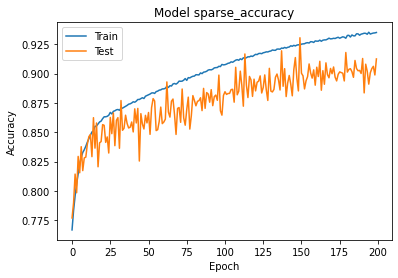

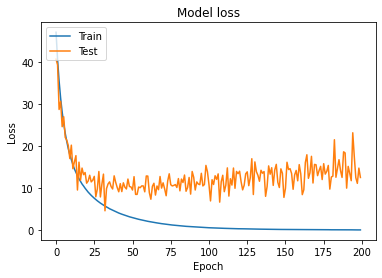

In [68]:
# keras可视化
import matplotlib.pyplot as plt

# history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

# 绘制训练 & 验证的准确率值
plt.plot(history.history['sparse_accuracy'])
plt.plot(history.history['val_sparse_accuracy'])
plt.title('Model sparse_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [30]:
# 得到无标签的句子
filePath = '/content/data/unlabeledSentences_unique.txt'
with open(filePath, encoding='utf-8',   ) as f:
    sents = f.read()
sents = sents.split('\n')
len(sents)

2005770

In [34]:
# sents = sents.split('\n')
len(sents)
text = sents[3]
print(text)
named_entity_recognize(text)

2.胸1椎体右侧横突骨折"收住入院


[('椎体右侧横突骨', 'BODY')]

In [84]:
def viterbi_decode_path(nodes, trans):

    labels = np.arange(num_labels).reshape((1, -1))
    scores = nodes[0].reshape((-1, 1))
    scores[1:] -= np.inf  # 第一个标签必然是0
    paths = labels
    for l in range(1, len(nodes)):
        M = scores + trans + nodes[l].reshape((1, -1))
        idxs = M.argmax(0)
        scores = M.max(0).reshape((-1, 1))
        paths = np.concatenate([paths[:, idxs], labels], 0)
        
    return paths

def get_label_paths(text):
# text = sents[7]
    tokens = tokenizer.tokenize(text)
    while len(tokens) > 512:
        tokens.pop(-2)
    token_ids = tokenizer.tokens_to_ids(tokens)
    segment_ids = [0] * len(token_ids)
    nodes = model.predict([[token_ids], [segment_ids]])[0]
    trans = K.eval(CRF.trans)
    # labels = viterbi_decode(nodes, trans)[1:-1]
    labels_paths = viterbi_decode_path(nodes, trans)[1:-1] # cls slp都不要
    return labels_paths

# 每一个字符的标签置信度
# def getLowestConfidence(text):
def getLowestConfidence(labels_paths): # 输入label_paths

    # labels_paths = get_label_paths(text)
    set_len = len(labels_paths[0])
    lowestConfidence = 1.0
    for char_labels in labels_paths:
        # 每个字符的最大置信度，即为最高的置信度
        char_best_conf = 0.0
        if len(list(set(char_labels))) == 1:
            char_best_conf = 1
            pass;
        else:
            res = collections.Counter(char_labels)
            for res_item in res:
                res[res_item] = res[res_item] / set_len
                # print(res[res_item])
                if char_best_conf < res[res_item]: # 
                    char_best_conf = res[res_item]
            # print(char_best_conf)
        if char_best_conf < lowestConfidence:
            lowestConfidence = char_best_conf
    return lowestConfidence

# 得到伪标签的数据，可以直接加入到train_data，效率堪忧
def get_pseudo_labeled_data(text):
    pseudo_labeled_data = named_entity_recognize(text)
    res = []
    for word in pseudo_labeled_data:
        res.append(list(word))
    return res

# 一句话的最低置信度的词儿
getLowestConfidence(sents[11])
# get_label_paths(sents[1])

1.0

In [102]:
# len(train_data_new)
train_data_new.append(1)
print('增加的数据量：', len(train_data_new) - len(train_data))

增加的数据量： 1


In [103]:
from tqdm import tqdm_notebook
import copy

train_data = load_data('/content/data/train.txt')
train_data_new = copy.deepcopy(train_data)# 必须用deepcopy

# threhold 设为0.95，高于这个阈值则可以加入到trainset
threhold = 0.95
# 如果整句话的字符最低置信度小于threhold，则该句不加入train_data
# 一句话的最低置信度的词儿
print(len(sents))

for sent in tqdm_notebook(sents[:]):
    text = sent
    labels_paths = get_label_paths(text)    
    if not list(labels_paths): # text 为空跳过
        continue;
    if getLowestConfidence(labels_paths) > threhold: # 略过
        # print(getLowestConfidence(labels_paths))
        # 加入到train_data
        pseudo_labeled_data = get_pseudo_labeled_data(text)
        train_data_new.append(pseudo_labeled_data)
        
# 进行训练查看效果是否有提升，弊端：需要一次性来，而不是增量来进行收集并训练。
print('增加的数据量：', len(train_data_new) - len(train_data))

32441


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



增加的数据量： 10155


In [0]:
class Evaluate(keras.callbacks.Callback):
    def __init__(self):
        self.best_val_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        trans = K.eval(CRF.trans)
        # print(trans)
        f1, precision, recall = evaluate(valid_data)
        # 保存最优
        if f1 >= self.best_val_f1:
            self.best_val_f1 = f1
            model.save_weights(weightPath)
            model.save(modelPath)
        print('valid:  f1: %.5f, precision: %.5f, recall: %.5f, best f1: %.5f\n' %
              (f1, precision, recall, self.best_val_f1))
        f1, precision, recall = evaluate(test_data)
        print('test:  f1: %.5f, precision: %.5f, recall: %.5f\n' %
              (f1, precision, recall))

In [0]:
# 二次训练,训练100个epoch，看f1是否有提高
epochs = 100
batch_size = 100

basePath = '/content/drive/My Drive/学习/命名主体识别/model/'
weightPath = basePath + '0329_albert_model.weights'
modelPath = basePath + '0329_albert_model.h5'
evalFunc = Evaluate()

train_new_generator = data_generator(train_data_new, batch_size)
test_generator = data_generator(test_data, batch_size)

history_new = model.fit_generator(train_new_generator.forfit(),
            steps_per_epoch=len(train_new_generator),
            validation_steps = 1,
            validation_data = test_generator.forfit(),
            epochs=epochs,
            callbacks=[evalFunc])

Epoch 1/100
112/112 [==============================] - 67s 600ms/step - loss: 2.0284 - sparse_accuracy: 0.8511 - val_loss: 10.1850 - val_sparse_accuracy: 0.8734





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 43.07it/s]


  9%|▉         | 11/119 [00:00<00:02, 46.98it/s]


 16%|█▌        | 19/119 [00:00<00:01, 52.77it/s]


 20%|██        | 24/119 [00:00<00:01, 51.09it/s]


 28%|██▊       | 33/119 [00:00<00:01, 56.81it/s]


 34%|███▍      | 41/119 [00:00<00:01, 60.64it/s]


 40%|████      | 48/119 [00:00<00:01, 59.55it/s]


 48%|████▊     | 57/119 [00:00<00:00, 65.35it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 62.31it/s]


 60%|█████▉    | 71/119 [00:01<00:00, 61.56it/s]


 66%|██████▌   | 78/119 [00:01<00:00, 59.40it/s]


 71%|███████▏  | 85/119 [00:01<00:00, 60.63it/s]


 77%|███████▋  | 92/119 [00:01<00:00, 58.03it/s]


 83%|████████▎ | 99/119 [00:01<00:00, 60.22it/s]


 89%|████████▉ | 106/119 [00:01<00:00, 56.39it/s]


100%|██████████| 119/119 [00:01<00:00, 61.09it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  6%|▌         | 7/119 [00:00<00:01, 64.71it/s]

valid:  f1: 0.80917, precision: 0.82847, recall: 0.79075, best f1: 0.80917






 14%|█▍        | 17/119 [00:00<00:01, 71.99it/s]


 21%|██        | 25/119 [00:00<00:01, 73.90it/s]


 27%|██▋       | 32/119 [00:00<00:01, 67.35it/s]


 32%|███▏      | 38/119 [00:00<00:01, 59.58it/s]


 37%|███▋      | 44/119 [00:00<00:01, 57.21it/s]


 44%|████▎     | 52/119 [00:00<00:01, 61.86it/s]


 50%|████▉     | 59/119 [00:00<00:00, 62.05it/s]


 55%|█████▌    | 66/119 [00:00<00:00, 64.08it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 63.26it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 66.94it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 67.73it/s]


 81%|████████  | 96/119 [00:01<00:00, 64.73it/s]


 87%|████████▋ | 103/119 [00:01<00:00, 65.96it/s]


 92%|█████████▏| 110/119 [00:01<00:00, 66.98it/s]


100%|██████████| 119/119 [00:01<00:00, 65.50it/s]


test:  f1: 0.80579, precision: 0.82472, recall: 0.78771

Epoch 2/100
112/112 [==============================] - 65s 577ms/step - loss: 1.6960 - sparse_accuracy: 0.8558 - val_loss: 11.9877 - val_sparse_accuracy: 0.8796





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 42.64it/s]


 10%|█         | 12/119 [00:00<00:02, 47.25it/s]


 17%|█▋        | 20/119 [00:00<00:01, 53.85it/s]


 21%|██        | 25/119 [00:00<00:01, 51.29it/s]


 29%|██▊       | 34/119 [00:00<00:01, 58.40it/s]


 35%|███▌      | 42/119 [00:00<00:01, 63.36it/s]


 41%|████      | 49/119 [00:00<00:01, 61.29it/s]


 48%|████▊     | 57/119 [00:00<00:00, 64.37it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 59.77it/s]


 60%|█████▉    | 71/119 [00:01<00:00, 57.52it/s]


 65%|██████▍   | 77/119 [00:01<00:00, 55.01it/s]


 70%|██████▉   | 83/119 [00:01<00:00, 56.03it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 56.95it/s]


 81%|████████  | 96/119 [00:01<00:00, 58.41it/s]


 87%|████████▋ | 103/119 [00:01<00:00, 61.03it/s]


 92%|█████████▏| 110/119 [00:01<00:00, 63.01it/s]


100%|██████████| 119/119 [00:01<00:00, 61.01it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 46.58i

valid:  f1: 0.81241, precision: 0.82544, recall: 0.79978, best f1: 0.81241






 11%|█         | 13/119 [00:00<00:02, 52.88it/s]


 16%|█▌        | 19/119 [00:00<00:01, 54.27it/s]


 23%|██▎       | 27/119 [00:00<00:01, 58.95it/s]


 28%|██▊       | 33/119 [00:00<00:01, 53.44it/s]


 32%|███▏      | 38/119 [00:00<00:01, 48.01it/s]


 37%|███▋      | 44/119 [00:00<00:01, 50.13it/s]


 45%|████▍     | 53/119 [00:00<00:01, 56.57it/s]


 50%|█████     | 60/119 [00:01<00:00, 59.42it/s]


 56%|█████▋    | 67/119 [00:01<00:00, 62.14it/s]


 62%|██████▏   | 74/119 [00:01<00:00, 61.72it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 64.62it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 65.87it/s]


 81%|████████  | 96/119 [00:01<00:00, 61.82it/s]


 87%|████████▋ | 104/119 [00:01<00:00, 65.24it/s]


 93%|█████████▎| 111/119 [00:01<00:00, 62.74it/s]


100%|██████████| 119/119 [00:01<00:00, 61.07it/s]


test:  f1: 0.81009, precision: 0.82189, recall: 0.79863

Epoch 3/100
112/112 [==============================] - 67s 594ms/step - loss: 1.5040 - sparse_accuracy: 0.8586 - val_loss: 9.0843 - val_sparse_accuracy: 0.8762





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 44.66it/s]


  9%|▉         | 11/119 [00:00<00:02, 48.12it/s]


 15%|█▌        | 18/119 [00:00<00:01, 53.08it/s]


 20%|██        | 24/119 [00:00<00:01, 54.12it/s]


 28%|██▊       | 33/119 [00:00<00:01, 60.25it/s]


 34%|███▎      | 40/119 [00:00<00:01, 62.76it/s]


 39%|███▉      | 47/119 [00:00<00:01, 64.69it/s]


 45%|████▌     | 54/119 [00:00<00:01, 63.10it/s]


 51%|█████▏    | 61/119 [00:00<00:00, 64.48it/s]


 57%|█████▋    | 68/119 [00:01<00:00, 58.91it/s]


 62%|██████▏   | 74/119 [00:01<00:00, 56.88it/s]


 67%|██████▋   | 80/119 [00:01<00:00, 53.49it/s]


 72%|███████▏  | 86/119 [00:01<00:00, 54.00it/s]


 77%|███████▋  | 92/119 [00:01<00:00, 52.78it/s]


 82%|████████▏ | 98/119 [00:01<00:00, 52.32it/s]


 87%|████████▋ | 104/119 [00:01<00:00, 54.37it/s]


 94%|█████████▍| 112/119 [00:01<00:00, 59.02it/s]


100%|██████████| 119/119 [00:01<00:00, 59.61it/s]



  0%|          | 0/119 [00:00<?, ?

valid:  f1: 0.81432, precision: 0.83214, recall: 0.79725, best f1: 0.81432






 14%|█▍        | 17/119 [00:00<00:01, 69.95it/s]


 20%|██        | 24/119 [00:00<00:01, 69.22it/s]


 24%|██▍       | 29/119 [00:00<00:01, 59.07it/s]


 29%|██▊       | 34/119 [00:00<00:01, 51.10it/s]


 33%|███▎      | 39/119 [00:00<00:01, 50.73it/s]


 37%|███▋      | 44/119 [00:00<00:01, 48.91it/s]


 45%|████▍     | 53/119 [00:00<00:01, 55.41it/s]


 50%|████▉     | 59/119 [00:00<00:01, 54.92it/s]


 55%|█████▌    | 66/119 [00:01<00:00, 58.25it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 58.06it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 62.28it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 62.31it/s]


 81%|████████  | 96/119 [00:01<00:00, 58.72it/s]


 86%|████████▌ | 102/119 [00:01<00:00, 58.85it/s]


 92%|█████████▏| 110/119 [00:01<00:00, 63.85it/s]


100%|██████████| 119/119 [00:01<00:00, 61.38it/s]


test:  f1: 0.81275, precision: 0.83220, recall: 0.79418

Epoch 4/100
112/112 [==============================] - 66s 586ms/step - loss: 1.3718 - sparse_accuracy: 0.8612 - val_loss: 12.4137 - val_sparse_accuracy: 0.8575





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 39.91it/s]


 10%|█         | 12/119 [00:00<00:02, 45.03it/s]


 18%|█▊        | 21/119 [00:00<00:01, 50.17it/s]


 24%|██▍       | 29/119 [00:00<00:01, 55.58it/s]


 31%|███       | 37/119 [00:00<00:01, 59.75it/s]


 37%|███▋      | 44/119 [00:00<00:01, 60.66it/s]


 44%|████▎     | 52/119 [00:00<00:01, 64.82it/s]


 50%|████▉     | 59/119 [00:00<00:00, 63.71it/s]


 55%|█████▌    | 66/119 [00:01<00:00, 59.49it/s]


 61%|██████    | 72/119 [00:01<00:00, 54.40it/s]


 66%|██████▌   | 78/119 [00:01<00:00, 54.32it/s]


 71%|███████▏  | 85/119 [00:01<00:00, 57.02it/s]


 76%|███████▋  | 91/119 [00:01<00:00, 56.08it/s]


 83%|████████▎ | 99/119 [00:01<00:00, 61.16it/s]


 89%|████████▉ | 106/119 [00:01<00:00, 60.17it/s]


100%|██████████| 119/119 [00:01<00:00, 61.89it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 47.93it/s]

valid:  f1: 0.81540, precision: 0.82738, recall: 0.80376, best f1: 0.81540






 12%|█▏        | 14/119 [00:00<00:01, 55.05it/s]


 18%|█▊        | 21/119 [00:00<00:01, 57.50it/s]


 24%|██▎       | 28/119 [00:00<00:01, 59.72it/s]


 29%|██▊       | 34/119 [00:00<00:01, 56.70it/s]


 34%|███▎      | 40/119 [00:00<00:01, 54.66it/s]


 41%|████      | 49/119 [00:00<00:01, 60.64it/s]


 48%|████▊     | 57/119 [00:00<00:00, 64.34it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 61.06it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 64.67it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 68.18it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 63.98it/s]


 81%|████████  | 96/119 [00:01<00:00, 62.27it/s]


 88%|████████▊ | 105/119 [00:01<00:00, 66.41it/s]


100%|██████████| 119/119 [00:01<00:00, 65.58it/s]


test:  f1: 0.81561, precision: 0.82854, recall: 0.80307

Epoch 5/100
112/112 [==============================] - 65s 580ms/step - loss: 1.2555 - sparse_accuracy: 0.8623 - val_loss: 9.7826 - val_sparse_accuracy: 0.8688





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 42.29it/s]


  8%|▊         | 10/119 [00:00<00:02, 43.59it/s]


 15%|█▌        | 18/119 [00:00<00:02, 49.08it/s]


 20%|██        | 24/119 [00:00<00:01, 51.28it/s]


 28%|██▊       | 33/119 [00:00<00:01, 57.22it/s]


 34%|███▍      | 41/119 [00:00<00:01, 61.06it/s]


 40%|████      | 48/119 [00:00<00:01, 61.57it/s]


 48%|████▊     | 57/119 [00:00<00:00, 66.82it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 59.90it/s]


 60%|█████▉    | 71/119 [00:01<00:00, 56.93it/s]


 65%|██████▍   | 77/119 [00:01<00:00, 51.46it/s]


 71%|███████   | 84/119 [00:01<00:00, 55.04it/s]


 76%|███████▌  | 90/119 [00:01<00:00, 54.00it/s]


 83%|████████▎ | 99/119 [00:01<00:00, 60.62it/s]


 89%|████████▉ | 106/119 [00:01<00:00, 58.44it/s]


100%|██████████| 119/119 [00:01<00:00, 60.74it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  6%|▌         | 7/119 [00:00<00:01, 65.55it/s]

valid:  f1: 0.81270, precision: 0.83032, recall: 0.79581, best f1: 0.81540






 13%|█▎        | 16/119 [00:00<00:01, 71.12it/s]


 20%|██        | 24/119 [00:00<00:01, 73.22it/s]


 25%|██▌       | 30/119 [00:00<00:01, 68.24it/s]


 30%|███       | 36/119 [00:00<00:01, 63.52it/s]


 35%|███▌      | 42/119 [00:00<00:01, 56.09it/s]


 43%|████▎     | 51/119 [00:00<00:01, 62.01it/s]


 49%|████▊     | 58/119 [00:00<00:01, 60.73it/s]


 54%|█████▍    | 64/119 [00:00<00:00, 59.80it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 64.17it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 69.16it/s]


 76%|███████▌  | 90/119 [00:01<00:00, 71.07it/s]


 82%|████████▏ | 98/119 [00:01<00:00, 63.69it/s]


 90%|████████▉ | 107/119 [00:01<00:00, 66.23it/s]


100%|██████████| 119/119 [00:01<00:00, 66.85it/s]


test:  f1: 0.81552, precision: 0.83270, recall: 0.79903

Epoch 6/100
112/112 [==============================] - 66s 587ms/step - loss: 1.1720 - sparse_accuracy: 0.8643 - val_loss: 7.8651 - val_sparse_accuracy: 0.8630





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 39.84it/s]


  9%|▉         | 11/119 [00:00<00:02, 44.23it/s]


 17%|█▋        | 20/119 [00:00<00:01, 51.78it/s]


 23%|██▎       | 27/119 [00:00<00:01, 54.85it/s]


 29%|██▉       | 35/119 [00:00<00:01, 58.91it/s]


 36%|███▌      | 43/119 [00:00<00:01, 62.67it/s]


 42%|████▏     | 50/119 [00:00<00:01, 64.50it/s]


 50%|████▉     | 59/119 [00:00<00:00, 66.29it/s]


 55%|█████▌    | 66/119 [00:01<00:00, 63.95it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 61.93it/s]


 67%|██████▋   | 80/119 [00:01<00:00, 60.55it/s]


 73%|███████▎  | 87/119 [00:01<00:00, 59.25it/s]


 78%|███████▊  | 93/119 [00:01<00:00, 57.93it/s]


 84%|████████▍ | 100/119 [00:01<00:00, 60.83it/s]


 90%|████████▉ | 107/119 [00:01<00:00, 60.03it/s]


100%|██████████| 119/119 [00:01<00:00, 63.43it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  6%|▌         | 7/119 [00:00<00:01, 67.03it/s]

valid:  f1: 0.81257, precision: 0.83163, recall: 0.79436, best f1: 0.81540






 14%|█▍        | 17/119 [00:00<00:01, 73.56it/s]


 20%|██        | 24/119 [00:00<00:01, 72.26it/s]


 26%|██▌       | 31/119 [00:00<00:01, 70.78it/s]


 31%|███       | 37/119 [00:00<00:01, 60.94it/s]


 36%|███▌      | 43/119 [00:00<00:01, 60.26it/s]


 43%|████▎     | 51/119 [00:00<00:01, 62.76it/s]


 49%|████▊     | 58/119 [00:00<00:00, 63.23it/s]


 55%|█████▍    | 65/119 [00:00<00:00, 61.63it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 63.11it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 67.86it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 66.46it/s]


 81%|████████  | 96/119 [00:01<00:00, 63.66it/s]


 88%|████████▊ | 105/119 [00:01<00:00, 68.26it/s]


100%|██████████| 119/119 [00:01<00:00, 66.93it/s]


test:  f1: 0.81422, precision: 0.83263, recall: 0.79660

Epoch 7/100
112/112 [==============================] - 66s 589ms/step - loss: 1.1034 - sparse_accuracy: 0.8642 - val_loss: 9.8084 - val_sparse_accuracy: 0.8680





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 42.74it/s]


  8%|▊         | 10/119 [00:00<00:02, 43.72it/s]


 15%|█▌        | 18/119 [00:00<00:01, 50.59it/s]


 20%|██        | 24/119 [00:00<00:01, 52.28it/s]


 28%|██▊       | 33/119 [00:00<00:01, 59.01it/s]


 34%|███▍      | 41/119 [00:00<00:01, 61.42it/s]


 40%|████      | 48/119 [00:00<00:01, 60.44it/s]


 48%|████▊     | 57/119 [00:00<00:00, 66.71it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 62.10it/s]


 60%|█████▉    | 71/119 [00:01<00:00, 60.35it/s]


 66%|██████▌   | 78/119 [00:01<00:00, 58.52it/s]


 71%|███████▏  | 85/119 [00:01<00:00, 60.58it/s]


 77%|███████▋  | 92/119 [00:01<00:00, 61.17it/s]


 84%|████████▍ | 100/119 [00:01<00:00, 64.61it/s]


 90%|████████▉ | 107/119 [00:01<00:00, 61.80it/s]


100%|██████████| 119/119 [00:01<00:00, 63.07it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  6%|▌         | 7/119 [00:00<00:01, 65.14it/s]

valid:  f1: 0.80938, precision: 0.82773, recall: 0.79183, best f1: 0.81540






 14%|█▍        | 17/119 [00:00<00:01, 72.16it/s]


 21%|██        | 25/119 [00:00<00:01, 74.20it/s]


 27%|██▋       | 32/119 [00:00<00:01, 67.77it/s]


 32%|███▏      | 38/119 [00:00<00:01, 59.44it/s]


 37%|███▋      | 44/119 [00:00<00:01, 57.12it/s]


 45%|████▍     | 53/119 [00:00<00:01, 62.41it/s]


 50%|█████     | 60/119 [00:00<00:00, 62.65it/s]


 56%|█████▋    | 67/119 [00:01<00:00, 64.69it/s]


 62%|██████▏   | 74/119 [00:01<00:00, 65.95it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 69.51it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 68.92it/s]


 81%|████████  | 96/119 [00:01<00:00, 62.74it/s]


 88%|████████▊ | 105/119 [00:01<00:00, 67.54it/s]


100%|██████████| 119/119 [00:01<00:00, 67.02it/s]


test:  f1: 0.81345, precision: 0.83059, recall: 0.79701

Epoch 8/100
112/112 [==============================] - 66s 587ms/step - loss: 1.0563 - sparse_accuracy: 0.8648 - val_loss: 7.6883 - val_sparse_accuracy: 0.8613





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 42.66it/s]


  8%|▊         | 10/119 [00:00<00:02, 44.12it/s]


 15%|█▌        | 18/119 [00:00<00:02, 49.18it/s]


 19%|█▉        | 23/119 [00:00<00:01, 49.26it/s]


 27%|██▋       | 32/119 [00:00<00:01, 56.39it/s]


 34%|███▎      | 40/119 [00:00<00:01, 59.42it/s]


 40%|████      | 48/119 [00:00<00:01, 60.38it/s]


 48%|████▊     | 57/119 [00:00<00:00, 66.62it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 63.24it/s]


 60%|█████▉    | 71/119 [00:01<00:00, 57.95it/s]


 65%|██████▍   | 77/119 [00:01<00:00, 55.08it/s]


 71%|███████   | 84/119 [00:01<00:00, 57.45it/s]


 76%|███████▌  | 90/119 [00:01<00:00, 54.34it/s]


 82%|████████▏ | 97/119 [00:01<00:00, 56.94it/s]


 87%|████████▋ | 103/119 [00:01<00:00, 55.44it/s]


 92%|█████████▏| 110/119 [00:01<00:00, 59.03it/s]


100%|██████████| 119/119 [00:01<00:00, 60.08it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  6%|▌         | 7/119 [00:00<00:01, 57.84i

valid:  f1: 0.81279, precision: 0.83691, recall: 0.79003, best f1: 0.81540






 15%|█▌        | 18/119 [00:00<00:01, 66.91it/s]


 21%|██        | 25/119 [00:00<00:01, 67.39it/s]


 26%|██▌       | 31/119 [00:00<00:01, 63.32it/s]


 31%|███       | 37/119 [00:00<00:01, 55.18it/s]


 35%|███▌      | 42/119 [00:00<00:01, 53.47it/s]


 43%|████▎     | 51/119 [00:00<00:01, 59.63it/s]


 49%|████▊     | 58/119 [00:00<00:01, 60.87it/s]


 55%|█████▍    | 65/119 [00:01<00:00, 62.23it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 64.82it/s]


 68%|██████▊   | 81/119 [00:01<00:00, 68.17it/s]


 74%|███████▍  | 88/119 [00:01<00:00, 63.95it/s]


 80%|███████▉  | 95/119 [00:01<00:00, 58.69it/s]


 86%|████████▌ | 102/119 [00:01<00:00, 59.28it/s]


 92%|█████████▏| 110/119 [00:01<00:00, 64.21it/s]


100%|██████████| 119/119 [00:01<00:00, 64.06it/s]


test:  f1: 0.81454, precision: 0.83732, recall: 0.79296

Epoch 9/100
112/112 [==============================] - 67s 599ms/step - loss: 0.9834 - sparse_accuracy: 0.8662 - val_loss: 9.4973 - val_sparse_accuracy: 0.8645





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 42.27it/s]


  8%|▊         | 10/119 [00:00<00:02, 43.99it/s]


 15%|█▌        | 18/119 [00:00<00:01, 50.52it/s]


 20%|██        | 24/119 [00:00<00:01, 52.12it/s]


 28%|██▊       | 33/119 [00:00<00:01, 57.11it/s]


 34%|███▎      | 40/119 [00:00<00:01, 59.84it/s]


 39%|███▊      | 46/119 [00:00<00:01, 57.53it/s]


 45%|████▍     | 53/119 [00:00<00:01, 60.37it/s]


 50%|█████     | 60/119 [00:00<00:00, 62.90it/s]


 56%|█████▋    | 67/119 [00:01<00:00, 59.42it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 58.20it/s]


 66%|██████▋   | 79/119 [00:01<00:00, 58.44it/s]


 71%|███████▏  | 85/119 [00:01<00:00, 58.67it/s]


 76%|███████▋  | 91/119 [00:01<00:00, 56.45it/s]


 84%|████████▍ | 100/119 [00:01<00:00, 62.68it/s]


 90%|████████▉ | 107/119 [00:01<00:00, 59.88it/s]


100%|██████████| 119/119 [00:01<00:00, 61.06it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 48.60i

valid:  f1: 0.81377, precision: 0.83416, recall: 0.79436, best f1: 0.81540






 13%|█▎        | 15/119 [00:00<00:01, 56.57it/s]


 19%|█▉        | 23/119 [00:00<00:01, 61.04it/s]


 26%|██▌       | 31/119 [00:00<00:01, 64.52it/s]


 31%|███       | 37/119 [00:00<00:01, 58.35it/s]


 36%|███▌      | 43/119 [00:00<00:01, 50.43it/s]


 42%|████▏     | 50/119 [00:00<00:01, 54.57it/s]


 48%|████▊     | 57/119 [00:00<00:01, 56.12it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 55.83it/s]


 61%|██████    | 72/119 [00:01<00:00, 60.59it/s]


 68%|██████▊   | 81/119 [00:01<00:00, 66.62it/s]


 74%|███████▍  | 88/119 [00:01<00:00, 67.56it/s]


 80%|███████▉  | 95/119 [00:01<00:00, 64.85it/s]


 86%|████████▌ | 102/119 [00:01<00:00, 64.69it/s]


 92%|█████████▏| 110/119 [00:01<00:00, 66.18it/s]


100%|██████████| 119/119 [00:01<00:00, 62.80it/s]


test:  f1: 0.81690, precision: 0.83737, recall: 0.79741

Epoch 10/100
112/112 [==============================] - 67s 595ms/step - loss: 0.9209 - sparse_accuracy: 0.8672 - val_loss: 10.2617 - val_sparse_accuracy: 0.8892





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 42.06it/s]


  8%|▊         | 10/119 [00:00<00:02, 43.14it/s]


 15%|█▌        | 18/119 [00:00<00:02, 48.82it/s]


 20%|██        | 24/119 [00:00<00:01, 49.83it/s]


 28%|██▊       | 33/119 [00:00<00:01, 56.63it/s]


 34%|███▍      | 41/119 [00:00<00:01, 60.40it/s]


 40%|████      | 48/119 [00:00<00:01, 60.94it/s]


 48%|████▊     | 57/119 [00:00<00:00, 67.05it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 63.31it/s]


 60%|█████▉    | 71/119 [00:01<00:00, 62.12it/s]


 66%|██████▌   | 78/119 [00:01<00:00, 58.35it/s]


 71%|███████   | 84/119 [00:01<00:00, 58.00it/s]


 76%|███████▌  | 90/119 [00:01<00:00, 57.22it/s]


 82%|████████▏ | 98/119 [00:01<00:00, 61.94it/s]


 88%|████████▊ | 105/119 [00:01<00:00, 61.16it/s]


100%|██████████| 119/119 [00:01<00:00, 62.35it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  3%|▎         | 4/119 [00:00<00:02, 39.22it/s]

valid:  f1: 0.81625, precision: 0.83459, recall: 0.79870, best f1: 0.81625






 12%|█▏        | 14/119 [00:00<00:02, 47.58it/s]


 17%|█▋        | 20/119 [00:00<00:01, 50.62it/s]


 24%|██▎       | 28/119 [00:00<00:01, 53.46it/s]


 28%|██▊       | 33/119 [00:00<00:01, 52.24it/s]


 32%|███▏      | 38/119 [00:00<00:01, 50.76it/s]


 37%|███▋      | 44/119 [00:00<00:01, 52.58it/s]


 44%|████▎     | 52/119 [00:00<00:01, 58.57it/s]


 49%|████▊     | 58/119 [00:00<00:01, 58.18it/s]


 54%|█████▍    | 64/119 [00:01<00:01, 54.96it/s]


 61%|██████    | 72/119 [00:01<00:00, 59.38it/s]


 66%|██████▋   | 79/119 [00:01<00:00, 61.31it/s]


 72%|███████▏  | 86/119 [00:01<00:00, 60.86it/s]


 78%|███████▊  | 93/119 [00:01<00:00, 57.77it/s]


 83%|████████▎ | 99/119 [00:01<00:00, 54.36it/s]


 90%|████████▉ | 107/119 [00:01<00:00, 59.62it/s]


100%|██████████| 119/119 [00:01<00:00, 60.13it/s]


test:  f1: 0.81752, precision: 0.83601, recall: 0.79984

Epoch 11/100
112/112 [==============================] - 66s 588ms/step - loss: 0.8814 - sparse_accuracy: 0.8684 - val_loss: 9.1646 - val_sparse_accuracy: 0.8686





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 45.56it/s]


  9%|▉         | 11/119 [00:00<00:02, 47.89it/s]


 15%|█▌        | 18/119 [00:00<00:01, 51.71it/s]


 20%|██        | 24/119 [00:00<00:01, 51.53it/s]


 27%|██▋       | 32/119 [00:00<00:01, 57.29it/s]


 32%|███▏      | 38/119 [00:00<00:01, 55.74it/s]


 37%|███▋      | 44/119 [00:00<00:01, 54.43it/s]


 45%|████▍     | 53/119 [00:00<00:01, 60.63it/s]


 50%|█████     | 60/119 [00:01<00:00, 59.98it/s]


 56%|█████▋    | 67/119 [00:01<00:00, 59.96it/s]


 62%|██████▏   | 74/119 [00:01<00:00, 57.37it/s]


 67%|██████▋   | 80/119 [00:01<00:00, 54.53it/s]


 72%|███████▏  | 86/119 [00:01<00:00, 55.21it/s]


 77%|███████▋  | 92/119 [00:01<00:00, 55.37it/s]


 83%|████████▎ | 99/119 [00:01<00:00, 57.92it/s]


 88%|████████▊ | 105/119 [00:01<00:00, 57.13it/s]


 94%|█████████▍| 112/119 [00:01<00:00, 60.29it/s]


100%|██████████| 119/119 [00:02<00:00, 58.40it/s]



  0%|          | 0/119 [00:00<?, ?

valid:  f1: 0.81562, precision: 0.83171, recall: 0.80014, best f1: 0.81625






 13%|█▎        | 16/119 [00:00<00:01, 68.54it/s]


 19%|█▉        | 23/119 [00:00<00:01, 67.97it/s]


 26%|██▌       | 31/119 [00:00<00:01, 69.79it/s]


 31%|███       | 37/119 [00:00<00:01, 60.86it/s]


 36%|███▌      | 43/119 [00:00<00:01, 56.68it/s]


 44%|████▎     | 52/119 [00:00<00:01, 62.25it/s]


 50%|████▉     | 59/119 [00:00<00:01, 59.30it/s]


 55%|█████▍    | 65/119 [00:01<00:00, 59.16it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 61.91it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 65.47it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 64.57it/s]


 81%|████████  | 96/119 [00:01<00:00, 58.12it/s]


 87%|████████▋ | 104/119 [00:01<00:00, 62.99it/s]


 93%|█████████▎| 111/119 [00:01<00:00, 63.21it/s]


100%|██████████| 119/119 [00:01<00:00, 63.48it/s]


test:  f1: 0.81880, precision: 0.83516, recall: 0.80307

Epoch 12/100
112/112 [==============================] - 66s 589ms/step - loss: 0.8278 - sparse_accuracy: 0.8688 - val_loss: 13.4382 - val_sparse_accuracy: 0.8637





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 46.00it/s]


  9%|▉         | 11/119 [00:00<00:02, 48.62it/s]


 16%|█▌        | 19/119 [00:00<00:01, 54.63it/s]


 21%|██        | 25/119 [00:00<00:01, 55.14it/s]


 28%|██▊       | 33/119 [00:00<00:01, 60.13it/s]


 34%|███▎      | 40/119 [00:00<00:01, 61.13it/s]


 39%|███▊      | 46/119 [00:00<00:01, 55.73it/s]


 45%|████▍     | 53/119 [00:00<00:01, 58.97it/s]


 50%|████▉     | 59/119 [00:00<00:01, 59.23it/s]


 55%|█████▌    | 66/119 [00:01<00:00, 59.03it/s]


 61%|██████    | 72/119 [00:01<00:00, 58.86it/s]


 66%|██████▌   | 78/119 [00:01<00:00, 54.23it/s]


 71%|███████   | 84/119 [00:01<00:00, 54.36it/s]


 76%|███████▌  | 90/119 [00:01<00:00, 52.41it/s]


 82%|████████▏ | 97/119 [00:01<00:00, 55.75it/s]


 87%|████████▋ | 104/119 [00:01<00:00, 58.62it/s]


 94%|█████████▍| 112/119 [00:01<00:00, 62.36it/s]


100%|██████████| 119/119 [00:01<00:00, 59.65it/s]



  0%|          | 0/119 [00:00<?, ?

valid:  f1: 0.81362, precision: 0.83384, recall: 0.79436, best f1: 0.81625






 13%|█▎        | 16/119 [00:00<00:01, 68.98it/s]


 19%|█▉        | 23/119 [00:00<00:01, 68.97it/s]


 25%|██▌       | 30/119 [00:00<00:01, 68.28it/s]


 30%|███       | 36/119 [00:00<00:01, 62.55it/s]


 35%|███▌      | 42/119 [00:00<00:01, 51.01it/s]


 42%|████▏     | 50/119 [00:00<00:01, 56.13it/s]


 48%|████▊     | 57/119 [00:00<00:01, 58.05it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 57.04it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 61.02it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 64.62it/s]


 75%|███████▍  | 89/119 [00:01<00:00, 64.97it/s]


 81%|████████  | 96/119 [00:01<00:00, 60.16it/s]


 87%|████████▋ | 103/119 [00:01<00:00, 58.09it/s]


 93%|█████████▎| 111/119 [00:01<00:00, 62.38it/s]


100%|██████████| 119/119 [00:01<00:00, 61.47it/s]


test:  f1: 0.81594, precision: 0.83802, recall: 0.79499

Epoch 13/100
112/112 [==============================] - 68s 603ms/step - loss: 0.7893 - sparse_accuracy: 0.8702 - val_loss: 10.7977 - val_sparse_accuracy: 0.8694





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 47.99it/s]


  8%|▊         | 10/119 [00:00<00:02, 48.32it/s]


 16%|█▌        | 19/119 [00:00<00:01, 55.55it/s]


 21%|██        | 25/119 [00:00<00:01, 54.87it/s]


 28%|██▊       | 33/119 [00:00<00:01, 59.18it/s]


 34%|███▎      | 40/119 [00:00<00:01, 60.58it/s]


 39%|███▊      | 46/119 [00:00<00:01, 59.29it/s]


 45%|████▌     | 54/119 [00:00<00:01, 62.64it/s]


 51%|█████▏    | 61/119 [00:00<00:00, 64.00it/s]


 57%|█████▋    | 68/119 [00:01<00:00, 58.40it/s]


 62%|██████▏   | 74/119 [00:01<00:00, 56.07it/s]


 67%|██████▋   | 80/119 [00:01<00:00, 56.06it/s]


 73%|███████▎  | 87/119 [00:01<00:00, 58.83it/s]


 78%|███████▊  | 93/119 [00:01<00:00, 58.94it/s]


 84%|████████▍ | 100/119 [00:01<00:00, 61.55it/s]


 90%|████████▉ | 107/119 [00:01<00:00, 58.29it/s]


100%|██████████| 119/119 [00:01<00:00, 60.73it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  6%|▌         | 7/119 [00:00<00:01, 58.15i

valid:  f1: 0.81263, precision: 0.83057, recall: 0.79545, best f1: 0.81625






 13%|█▎        | 15/119 [00:00<00:01, 62.92it/s]


 18%|█▊        | 22/119 [00:00<00:01, 62.93it/s]


 24%|██▍       | 29/119 [00:00<00:01, 63.75it/s]


 29%|██▉       | 35/119 [00:00<00:01, 60.35it/s]


 34%|███▍      | 41/119 [00:00<00:01, 56.03it/s]


 41%|████      | 49/119 [00:00<00:01, 61.56it/s]


 48%|████▊     | 57/119 [00:00<00:00, 64.57it/s]


 54%|█████▍    | 64/119 [00:01<00:00, 59.77it/s]


 61%|██████▏   | 73/119 [00:01<00:00, 63.91it/s]


 69%|██████▉   | 82/119 [00:01<00:00, 68.87it/s]


 76%|███████▌  | 90/119 [00:01<00:00, 64.88it/s]


 82%|████████▏ | 97/119 [00:01<00:00, 59.04it/s]


 88%|████████▊ | 105/119 [00:01<00:00, 62.93it/s]


100%|██████████| 119/119 [00:01<00:00, 63.46it/s]


test:  f1: 0.81241, precision: 0.83150, recall: 0.79418

Epoch 14/100
112/112 [==============================] - 67s 594ms/step - loss: 0.7540 - sparse_accuracy: 0.8711 - val_loss: 6.3053 - val_sparse_accuracy: 0.8694





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 43.85it/s]


  9%|▉         | 11/119 [00:00<00:02, 47.48it/s]


 16%|█▌        | 19/119 [00:00<00:01, 52.68it/s]


 20%|██        | 24/119 [00:00<00:01, 51.31it/s]


 28%|██▊       | 33/119 [00:00<00:01, 55.59it/s]


 34%|███▎      | 40/119 [00:00<00:01, 57.86it/s]


 39%|███▉      | 47/119 [00:00<00:01, 60.72it/s]


 45%|████▌     | 54/119 [00:00<00:01, 62.10it/s]


 52%|█████▏    | 62/119 [00:01<00:00, 62.43it/s]


 58%|█████▊    | 69/119 [00:01<00:00, 61.27it/s]


 64%|██████▍   | 76/119 [00:01<00:00, 55.65it/s]


 70%|██████▉   | 83/119 [00:01<00:00, 57.61it/s]


 76%|███████▌  | 90/119 [00:01<00:00, 57.80it/s]


 82%|████████▏ | 97/119 [00:01<00:00, 59.73it/s]


 87%|████████▋ | 104/119 [00:01<00:00, 58.27it/s]


 94%|█████████▍| 112/119 [00:01<00:00, 62.74it/s]


100%|██████████| 119/119 [00:01<00:00, 60.79it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  5%|▌         | 6/119 [00:00<00:01, 59.09i

valid:  f1: 0.81461, precision: 0.82768, recall: 0.80195, best f1: 0.81625






 13%|█▎        | 15/119 [00:00<00:01, 63.75it/s]


 19%|█▉        | 23/119 [00:00<00:01, 66.80it/s]


 24%|██▍       | 29/119 [00:00<00:01, 62.16it/s]


 29%|██▊       | 34/119 [00:00<00:01, 56.68it/s]


 34%|███▎      | 40/119 [00:00<00:01, 54.61it/s]


 40%|████      | 48/119 [00:00<00:01, 59.69it/s]


 47%|████▋     | 56/119 [00:00<00:00, 64.16it/s]


 53%|█████▎    | 63/119 [00:00<00:00, 60.68it/s]


 60%|█████▉    | 71/119 [00:01<00:00, 64.79it/s]


 66%|██████▌   | 78/119 [00:01<00:00, 62.94it/s]


 72%|███████▏  | 86/119 [00:01<00:00, 66.03it/s]


 78%|███████▊  | 93/119 [00:01<00:00, 65.09it/s]


 84%|████████▍ | 100/119 [00:01<00:00, 60.09it/s]


 90%|████████▉ | 107/119 [00:01<00:00, 62.64it/s]


100%|██████████| 119/119 [00:01<00:00, 63.12it/s]


test:  f1: 0.81605, precision: 0.83075, recall: 0.80186

Epoch 15/100
112/112 [==============================] - 66s 588ms/step - loss: 0.7166 - sparse_accuracy: 0.8710 - val_loss: 8.6610 - val_sparse_accuracy: 0.8752





  0%|          | 0/119 [00:00<?, ?it/s]


  4%|▍         | 5/119 [00:00<00:02, 45.03it/s]


  9%|▉         | 11/119 [00:00<00:02, 48.29it/s]


 16%|█▌        | 19/119 [00:00<00:01, 54.04it/s]


 21%|██        | 25/119 [00:00<00:01, 54.82it/s]


 28%|██▊       | 33/119 [00:00<00:01, 57.09it/s]


 34%|███▎      | 40/119 [00:00<00:01, 59.18it/s]


 39%|███▉      | 47/119 [00:00<00:01, 61.63it/s]


 45%|████▌     | 54/119 [00:00<00:01, 63.16it/s]


 52%|█████▏    | 62/119 [00:00<00:00, 64.15it/s]


 58%|█████▊    | 69/119 [00:01<00:00, 62.42it/s]


 64%|██████▍   | 76/119 [00:01<00:00, 53.42it/s]


 70%|██████▉   | 83/119 [00:01<00:00, 56.78it/s]


 76%|███████▌  | 90/119 [00:01<00:00, 55.63it/s]


 81%|████████  | 96/119 [00:01<00:00, 56.86it/s]


 87%|████████▋ | 103/119 [00:01<00:00, 58.75it/s]


 92%|█████████▏| 110/119 [00:01<00:00, 60.55it/s]


100%|██████████| 119/119 [00:01<00:00, 60.01it/s]



  0%|          | 0/119 [00:00<?, ?it/s]


  6%|▌         | 7/119 [00:00<00:01, 65.88i

valid:  f1: 0.80901, precision: 0.82655, recall: 0.79219, best f1: 0.81625






 14%|█▍        | 17/119 [00:00<00:01, 73.30it/s]


 22%|██▏       | 26/119 [00:00<00:01, 73.78it/s]


 27%|██▋       | 32/119 [00:00<00:01, 68.40it/s]


 32%|███▏      | 38/119 [00:00<00:01, 57.91it/s]


 37%|███▋      | 44/119 [00:00<00:01, 56.75it/s]


 45%|████▍     | 53/119 [00:00<00:01, 62.72it/s]


 50%|█████     | 60/119 [00:00<00:00, 63.00it/s]


 56%|█████▋    | 67/119 [00:01<00:00, 64.87it/s]


 62%|██████▏   | 74/119 [00:01<00:00, 65.50it/s]


 70%|██████▉   | 83/119 [00:01<00:00, 68.13it/s]


 76%|███████▋  | 91/119 [00:01<00:00, 70.06it/s]


 83%|████████▎ | 99/119 [00:01<00:00, 63.94it/s]


 90%|████████▉ | 107/119 [00:01<00:00, 65.70it/s]


100%|██████████| 119/119 [00:01<00:00, 66.84it/s]


test:  f1: 0.81743, precision: 0.83937, recall: 0.79660

Epoch 16/100
 72/112 [==================>...........] - ETA: 23s - loss: 0.6736 - sparse_accuracy: 0.8726

In [64]:
# 查看所有的词的置信度
text = sents[1]
# text = '患者神清，精神可，饮食可，二便可，查体：生命体征平稳，腰椎压痛明显减轻，患者今日要求出院，同意出院'
print('test_len',len(text))
import collections

labels_paths = get_label_paths(text)
set_len = len(labels_paths[0])
for char_labels in labels_paths:
    if len(list(set(char_labels))) == 1:
        res = {}
        res[char_labels[0]] = 1.0
        # print(res)
    else:
        res = collections.Counter(char_labels)
        for res_item in res:
            res[res_item] = res[res_item] / set_len
        print(dict(res))

test_len 90
{4: 0.9375, 8: 0.0625}
{0: 0.9375, 8: 0.0625}
{0: 0.9375, 8: 0.0625}


In [0]:
# 如果是 就把之前的history和新数据集的